In [1]:
import pandas as pd
from stock_prediction.commons import DEFAULT_DATA_EXTRACTION_OUTPUT_PATH
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_all_symbols = pd.read_csv(DEFAULT_DATA_EXTRACTION_OUTPUT_PATH)
df_all_symbols["Date"] = df_all_symbols["Date"].apply(lambda x: pd.Timestamp(x))
df_all_symbols = df_all_symbols.set_index("Date")

## Data Cleaning

In [3]:
first_index = df_all_symbols.isna().sum()

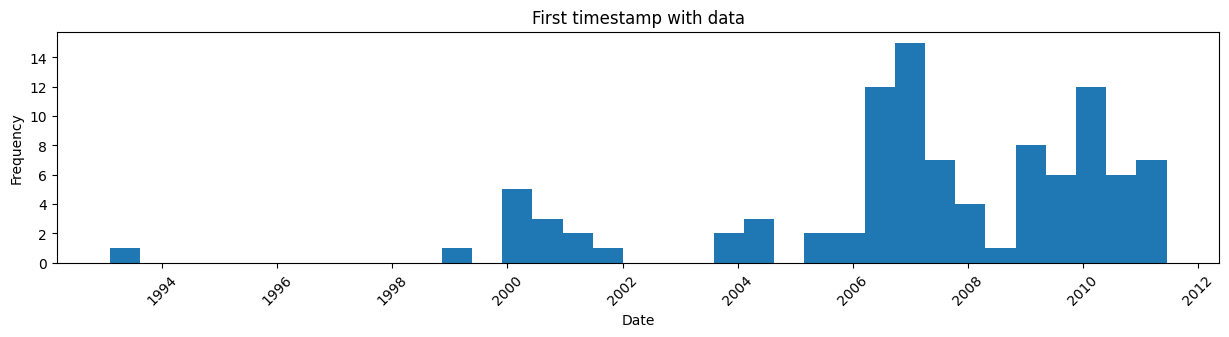

Date
count                        100
mean   2007-02-21 08:24:00+00:00
min    1993-02-01 00:00:00+00:00
25%    2006-05-08 00:00:00+00:00
50%    2007-05-09 12:00:00+00:00
75%    2009-11-19 12:00:00+00:00
max    2011-06-17 00:00:00+00:00

In [4]:
min_timestamps = pd.DataFrame(df_all_symbols.index[first_index])
plt.figure(figsize=(15, 3))
plt.hist(min_timestamps, bins=35)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("First timestamp with data")
plt.show()
min_timestamps.describe()

We can see that all symbols start more than 13 year ago, so it should be ok to just clip all the rows with NA. 

In [5]:
df_all_symbols_clipped = df_all_symbols[
    df_all_symbols.index >= df_all_symbols.index[first_index].max()
]

In [6]:
df_all_symbols_clipped.shape

(3318, 100)

In [7]:
df_all_symbols_clipped.isna().sum().describe()

count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

## Data Understanding

### Univariate Statistics

In [8]:
df_series_description = df_all_symbols_clipped.describe().T.drop("count", axis=1)
df_series_description

mean       std       min       25%       50%       75%       max
BIB   0.001086  0.030705 -0.196629 -0.016073  0.002044  0.018310  0.183601
CSM   0.000506  0.011135 -0.115944 -0.004183  0.000807  0.005745  0.094997
CURE  0.001489  0.030800 -0.298353 -0.013030  0.002107  0.017544  0.237088
DDM   0.000890  0.020991 -0.231843 -0.007419  0.001336  0.010586  0.224601
DSI   0.000515  0.011160 -0.120521 -0.003966  0.000637  0.005933  0.100190
...        ...       ...       ...       ...       ...       ...       ...
VOT   0.000476  0.012777 -0.130237 -0.005257  0.000937  0.007075  0.105889
VTHR  0.000493  0.010801 -0.094494 -0.003686  0.000603  0.005708  0.088787
XHE   0.000454  0.013503 -0.085537 -0.006152  0.000895  0.007921  0.093513
XMMO  0.000601  0.013229 -0.139295 -0.005510  0.001033  0.007505  0.104187
XSVM  0.000497  0.015035 -0.115320 -0.007006  0.000470  0.008165  0.085549

[100 rows x 7 columns]

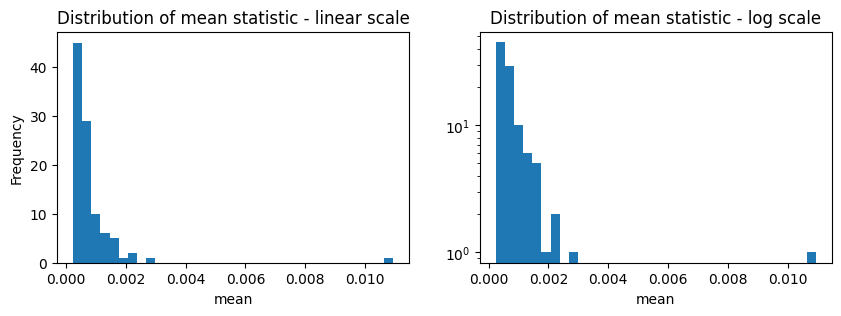

count    100.000000
mean       0.000849
std        0.001106
min        0.000235
25%        0.000503
50%        0.000559
75%        0.000869
max        0.010936
Name: mean, dtype: float64


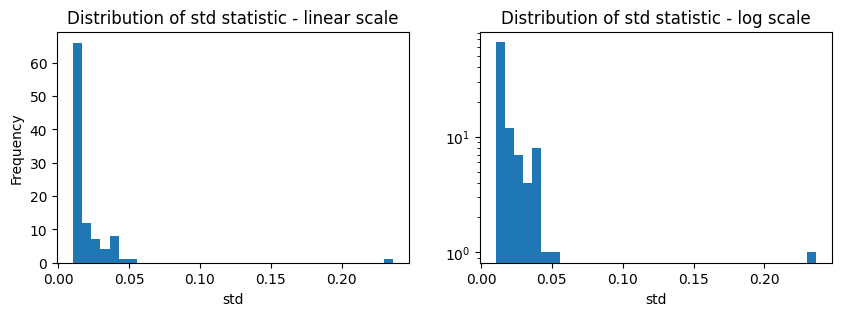

count    100.000000
mean       0.020180
std        0.023859
min        0.010310
25%        0.011760
50%        0.013630
75%        0.020888
max        0.236381
Name: std, dtype: float64


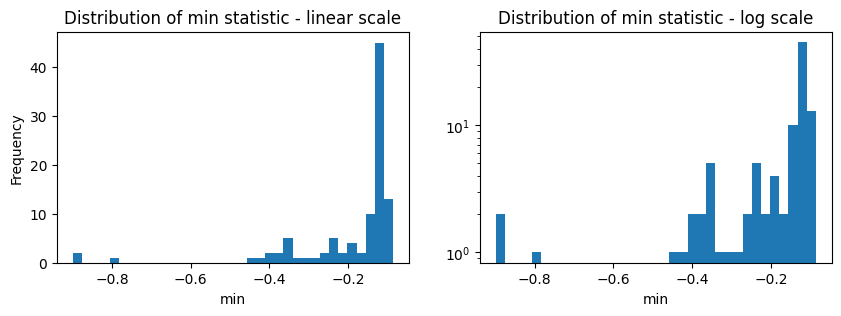

count    100.000000
mean      -0.190934
std        0.148752
min       -0.898880
25%       -0.203009
50%       -0.127630
75%       -0.117231
max       -0.085537
Name: min, dtype: float64


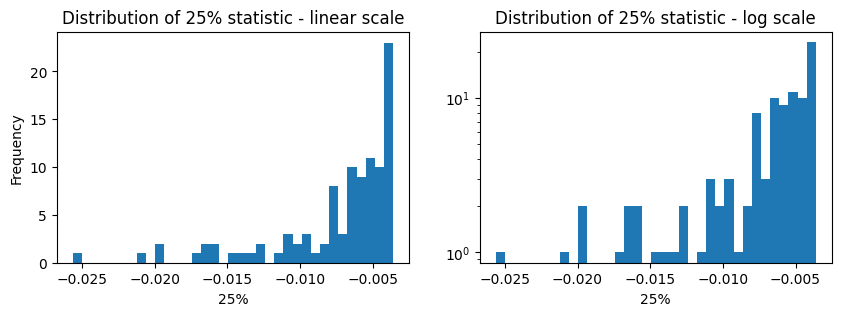

count    100.000000
mean      -0.007431
std        0.004439
min       -0.025634
25%       -0.008216
50%       -0.005843
75%       -0.004295
max       -0.003598
Name: 25%, dtype: float64


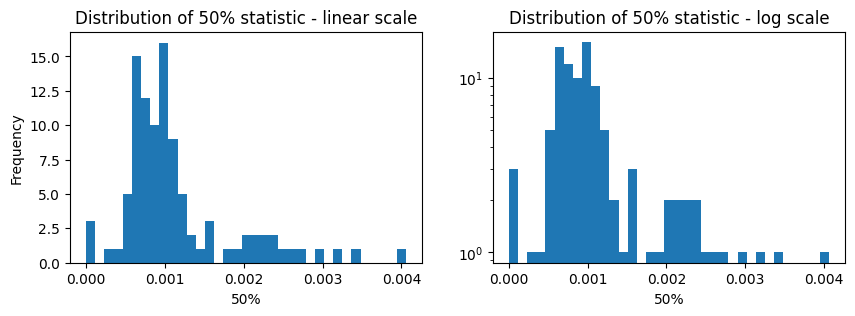

count    100.000000
mean       0.001141
std        0.000732
min        0.000000
25%        0.000699
50%        0.000956
75%        0.001242
max        0.004062
Name: 50%, dtype: float64


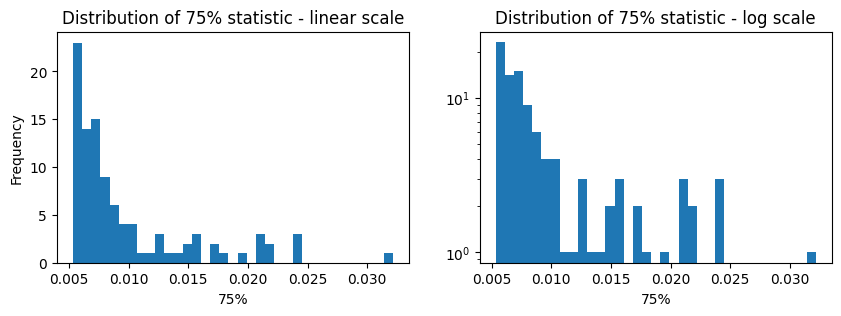

count    100.000000
mean       0.009824
std        0.005455
min        0.005328
25%        0.006280
50%        0.007462
75%        0.010779
max        0.032174
Name: 75%, dtype: float64


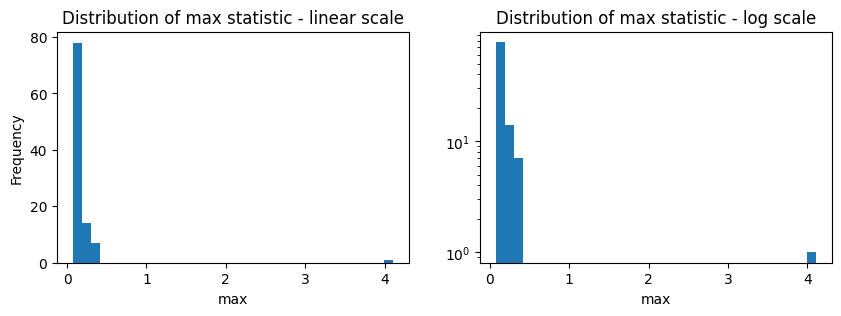

count    100.000000
mean       0.178098
std        0.403695
min        0.074038
25%        0.093507
50%        0.099232
75%        0.168318
max        4.106976
Name: max, dtype: float64


In [9]:
for col in df_series_description.columns:
    # Make a figure with two hists one with a line and one with a log scale side by side
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.hist(df_series_description[col], bins=35)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col} statistic - linear scale")
    plt.subplot(1, 2, 2)
    plt.hist(df_series_description[col], bins=35)
    plt.xlabel(col)
    plt.yscale("log")
    plt.title(f"Distribution of {col} statistic - log scale")
    plt.show()
    print(df_series_description[col].describe())

As we can see from the distributions above we have a skew towards positive returns, with the median of the various symbols having a distribution of positive values. This is consistent with the fact that we selected high performing symbols.

The distribution of std also shows that we have a distribution of daily volatility over the whole timespan of the dataset ranging from a minimum of about 0.01 with a mean value of about 0.02 and a max value of about 0.24 (i.e., typical daily variations of around 2% with a long tail up to large variations of about 24%).

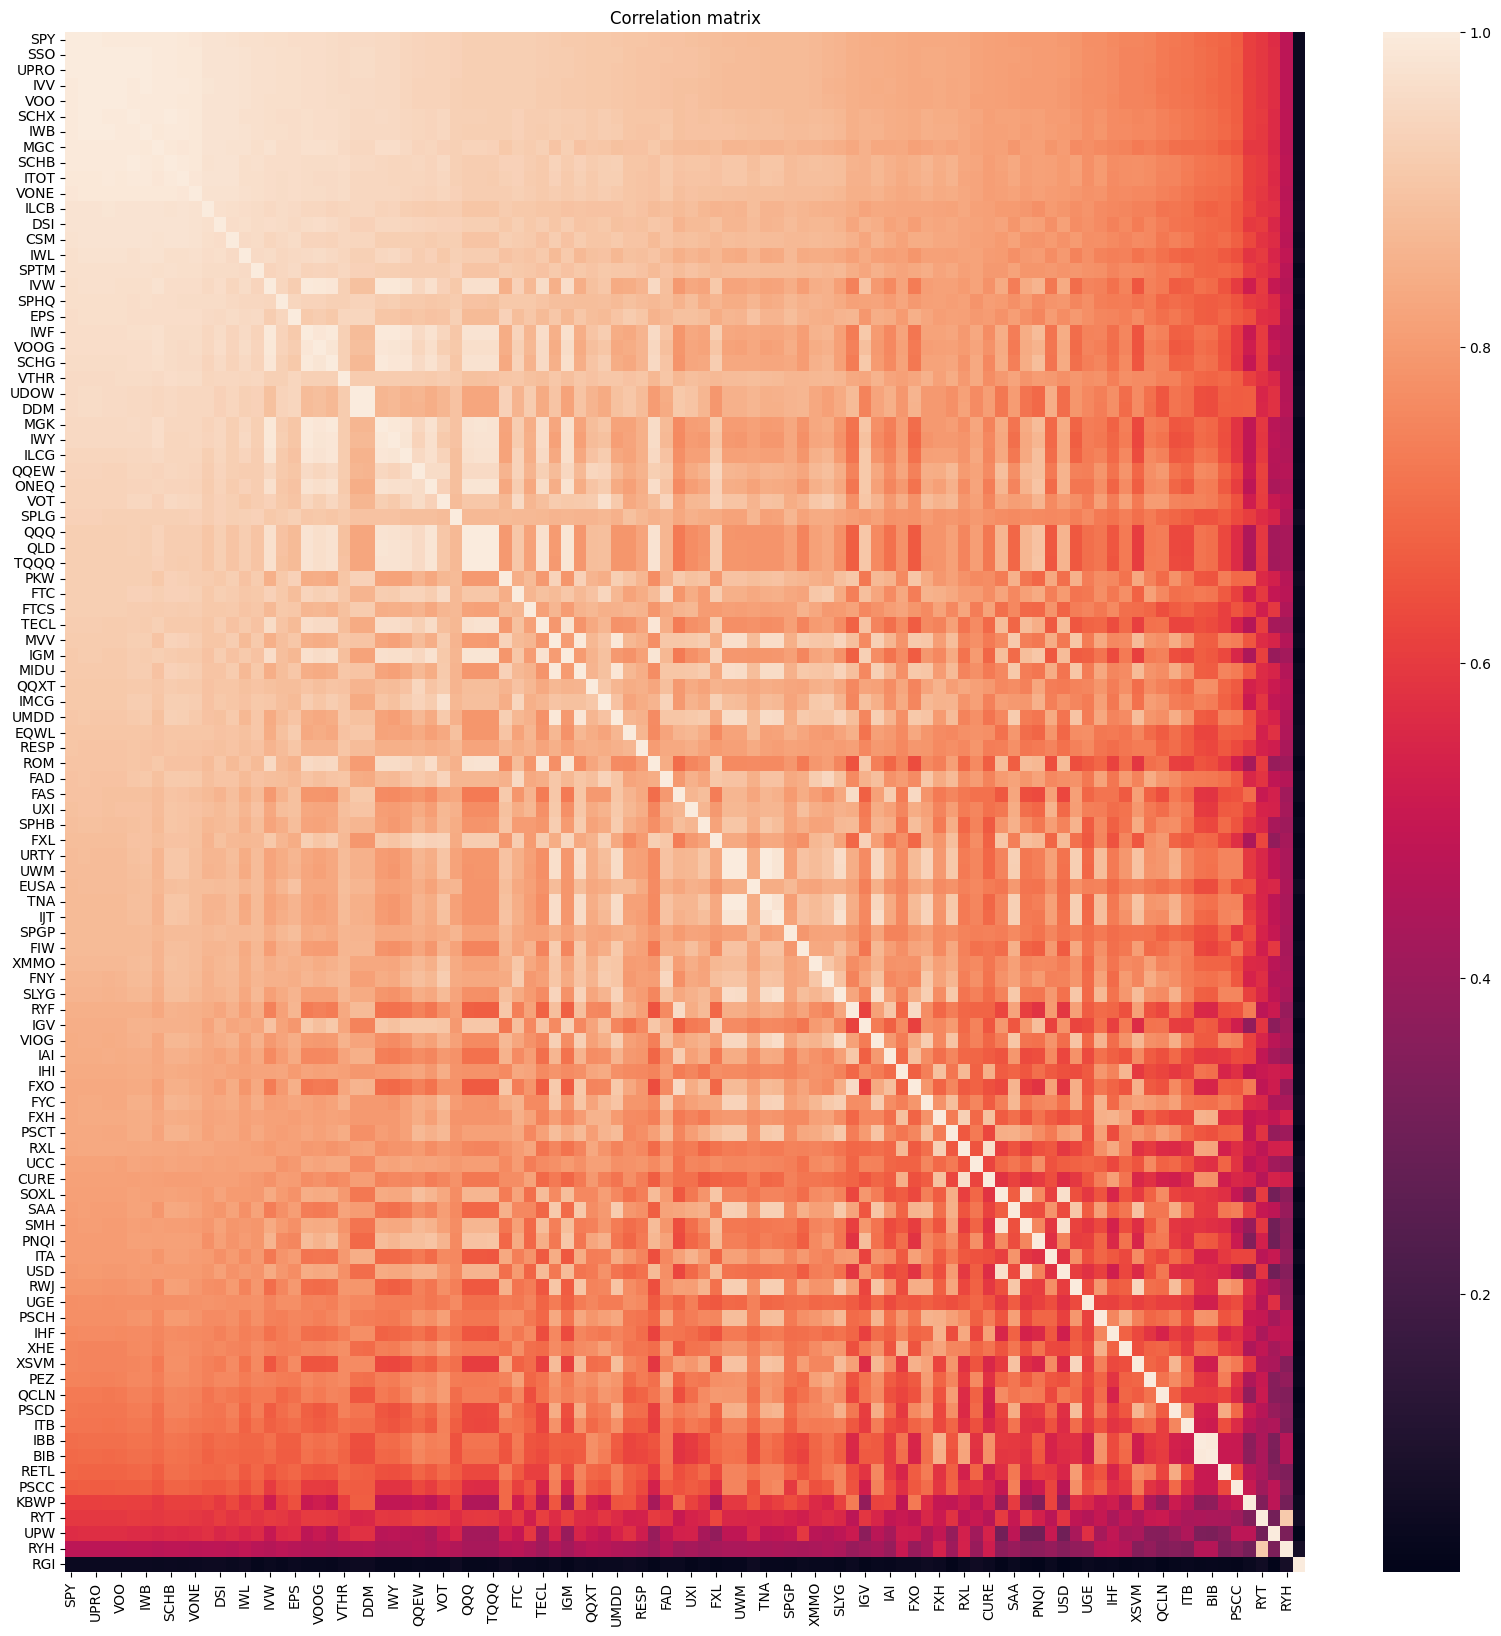

In [10]:
# Make a heatmap of the correlations

import seaborn as sns

df_corrs = df_all_symbols_clipped.corr()
cols_order = df_corrs.sort_values(by="SPY", ascending=False).index
plt.figure(figsize=(20, 20))
sns.heatmap(df_corrs.loc[cols_order, cols_order], annot=False)
plt.title("Correlation matrix")
plt.show()

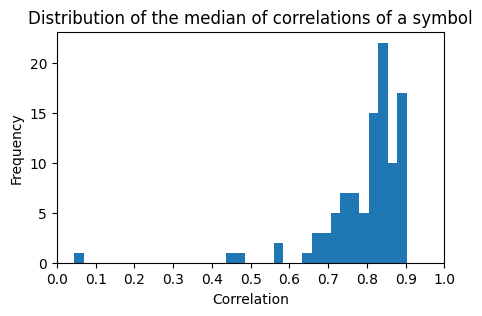

count    100.000000
mean       0.797121
std        0.114487
min        0.045058
25%        0.763675
50%        0.828067
75%        0.864841
max        0.902514
Name: 50%, dtype: float64

In [11]:
plt.figure(figsize=(5, 3))
plt.hist(df_corrs.describe().T["50%"], bins=35)
plt.title("Distribution of the median of correlations of a symbol")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
# set xticks to 0.1 increments up to and including 1
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()
df_corrs.describe().T["50%"].describe()

From the heatmap and the histogram we observe that most symbols have a high positive correlation though none are perfectly correlated (max of about 0.9) and there is a considerable tail with a median of median correlations of about 0.82 and a few values below 0.7.

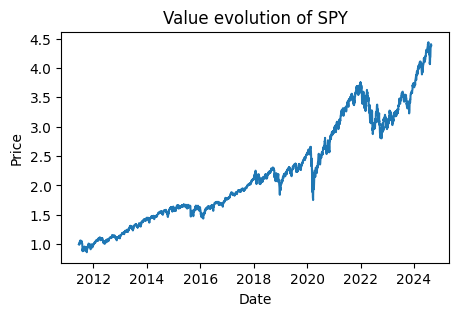

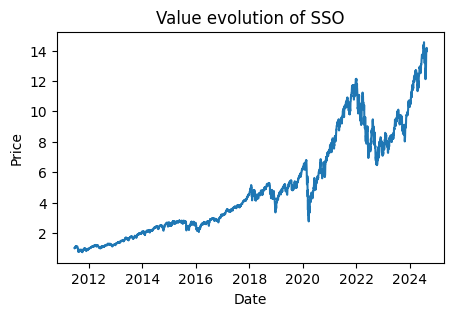

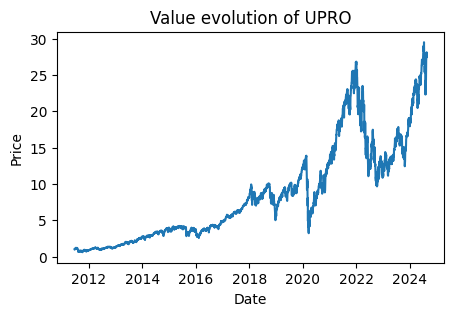

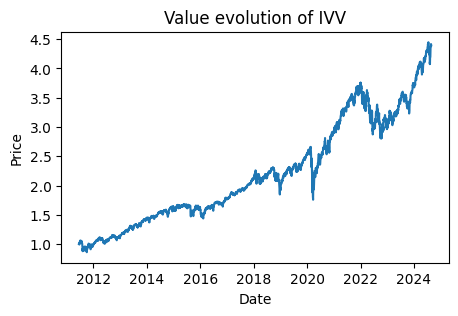

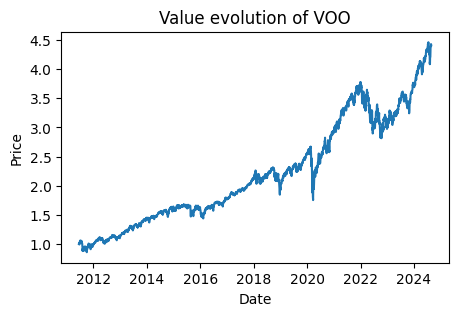

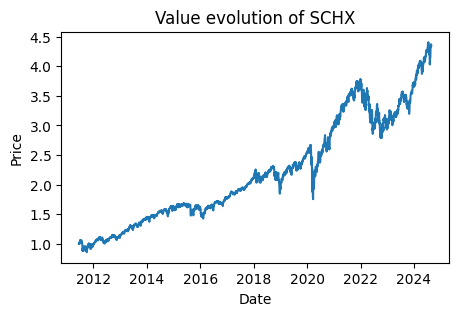

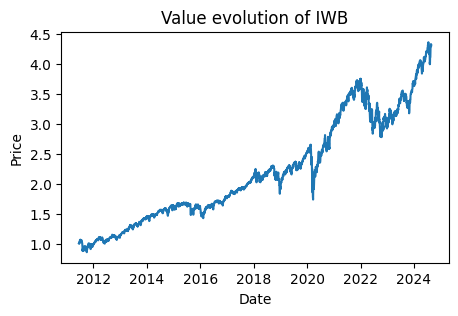

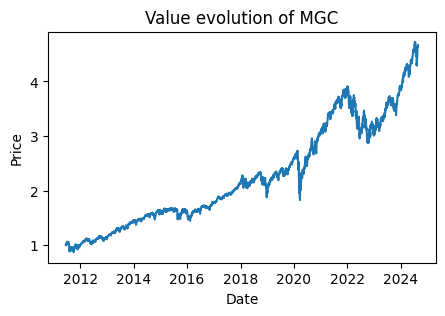

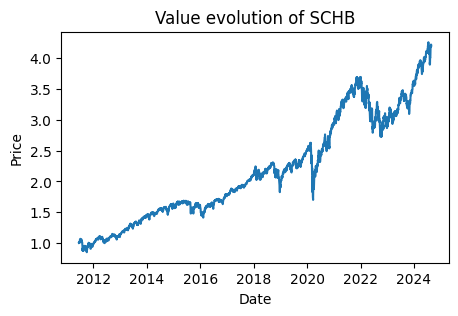

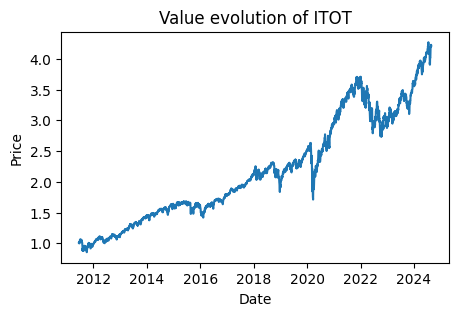

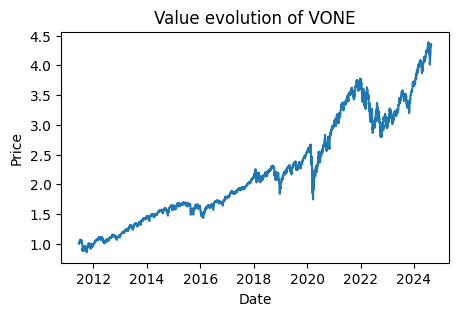

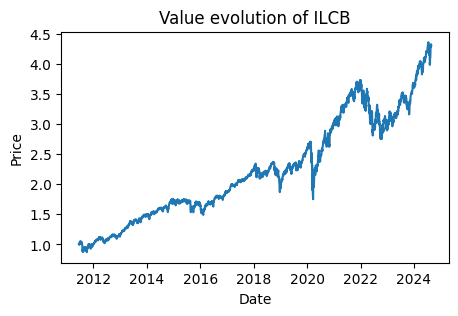

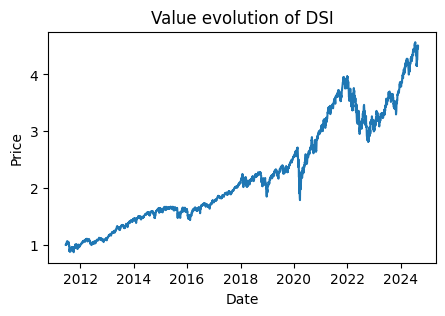

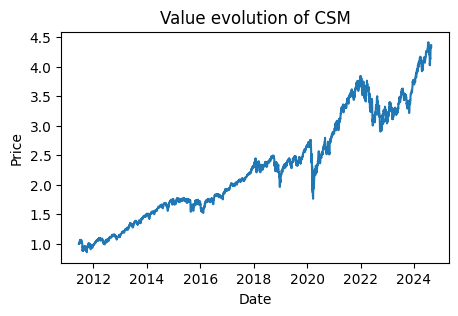

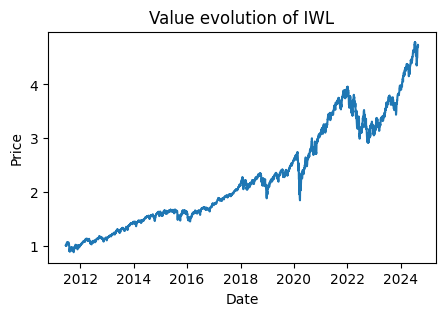

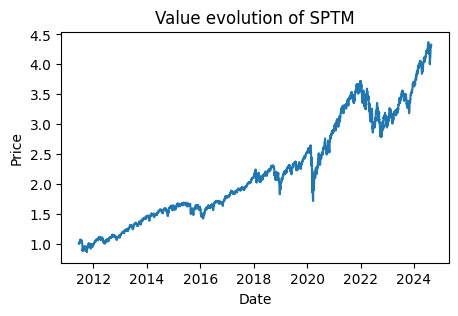

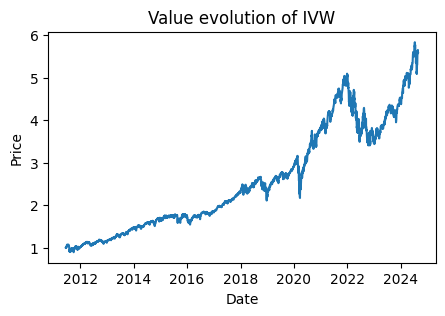

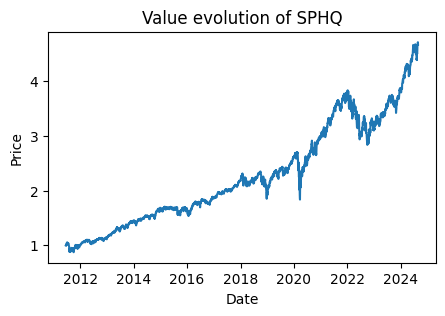

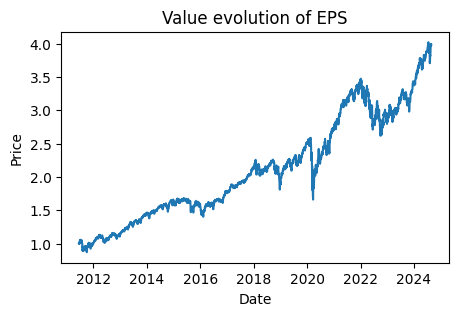

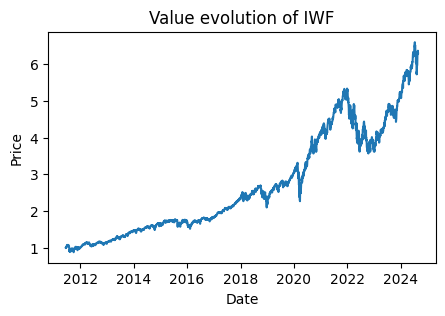

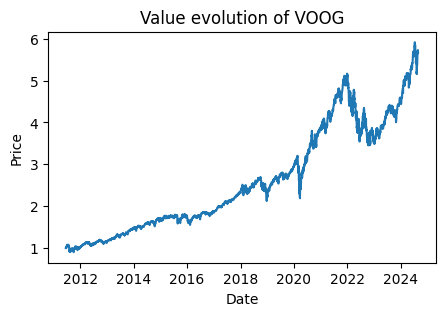

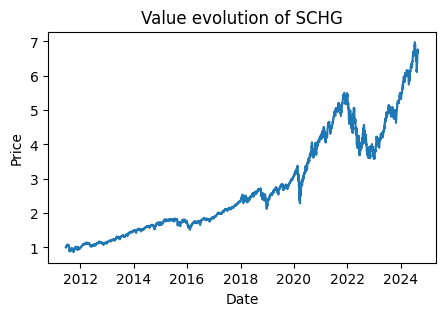

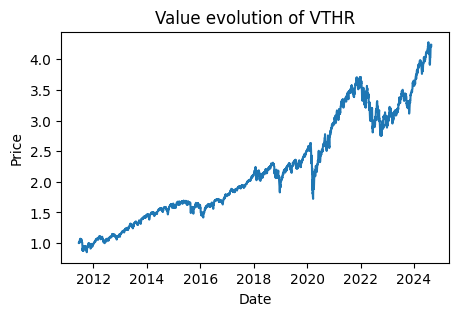

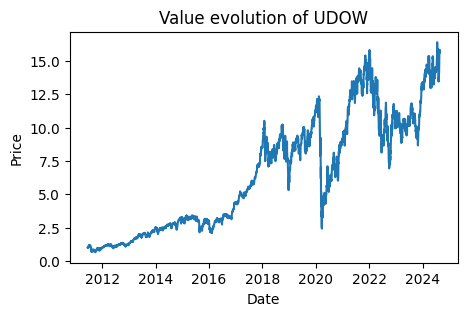

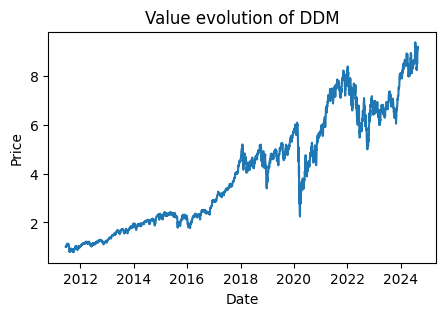

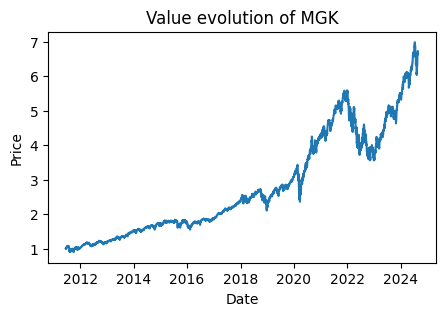

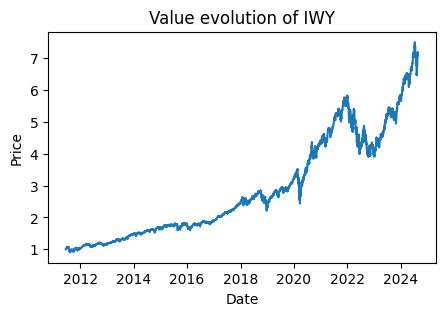

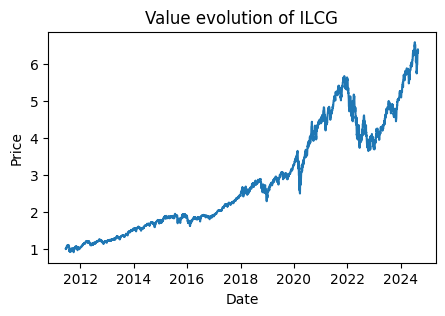

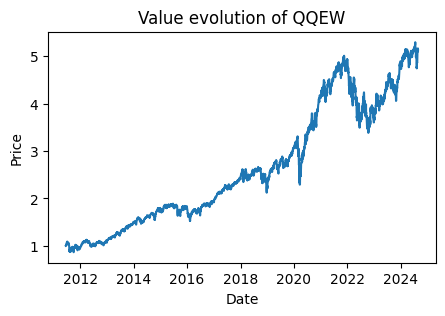

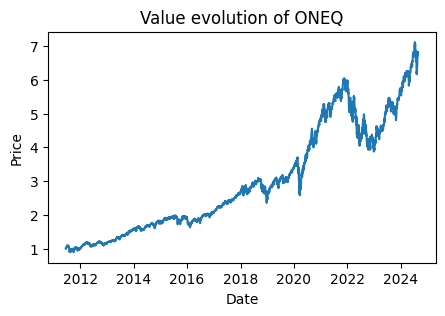

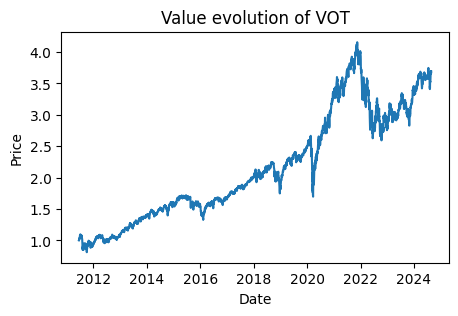

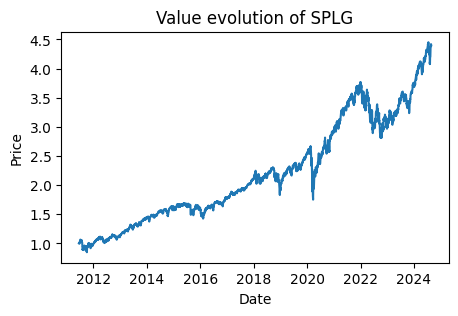

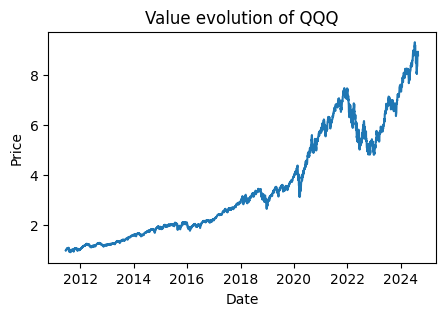

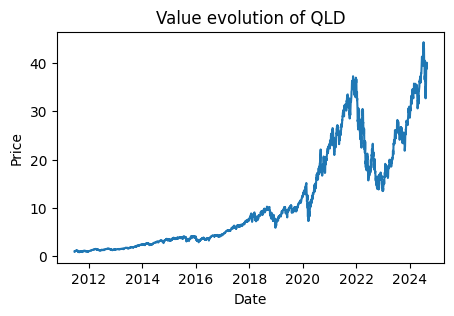

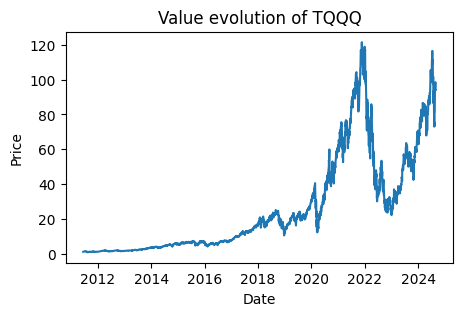

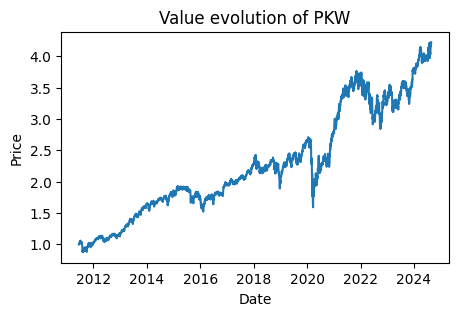

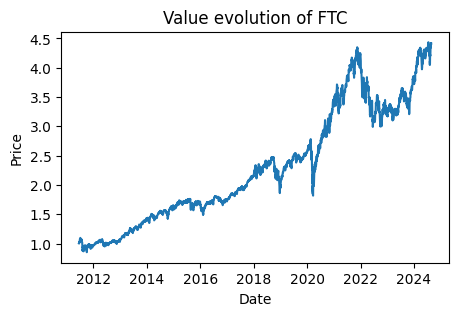

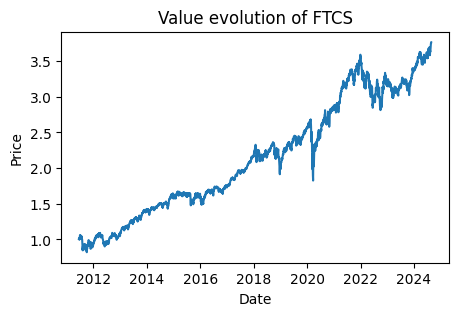

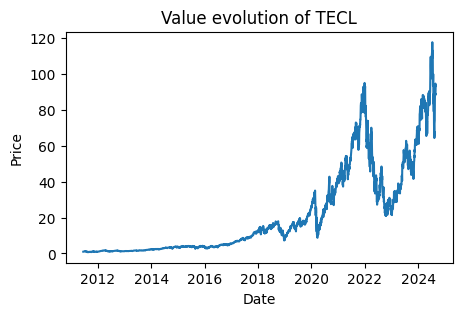

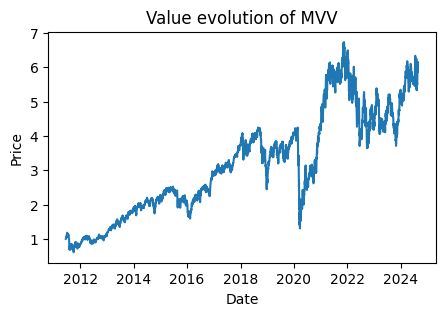

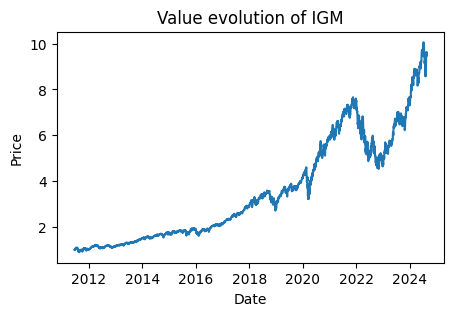

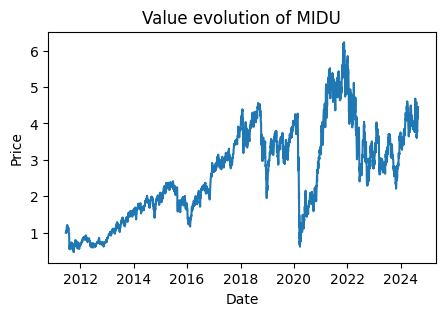

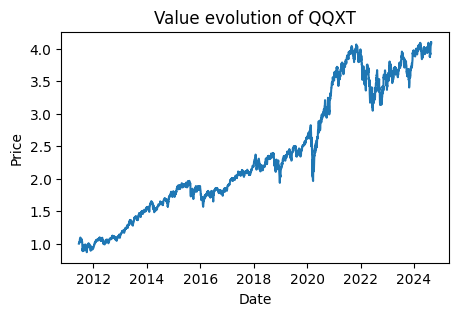

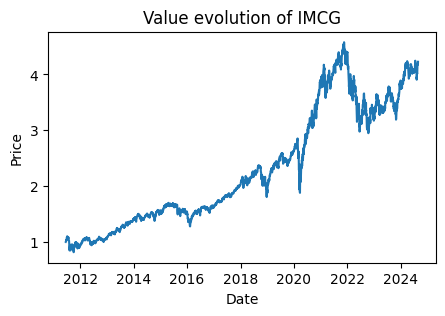

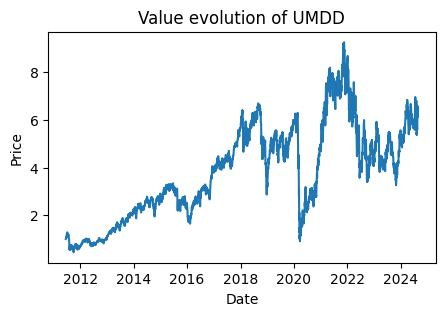

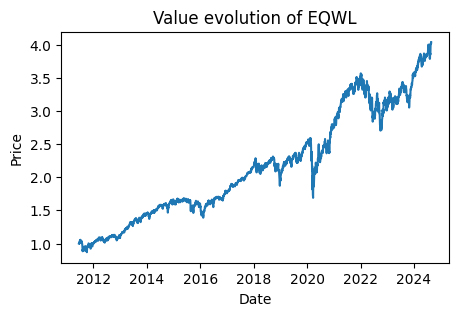

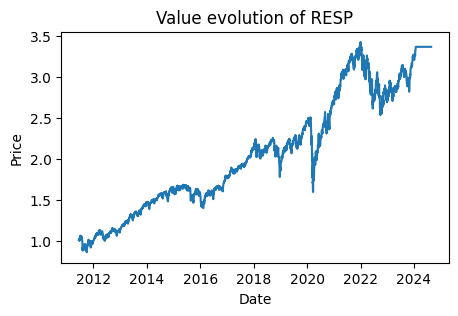

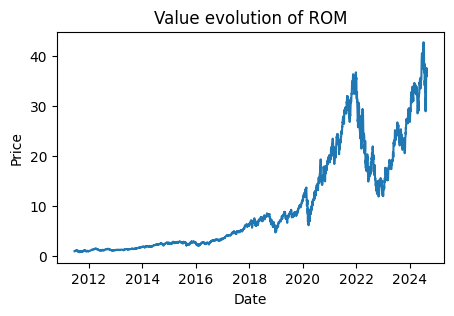

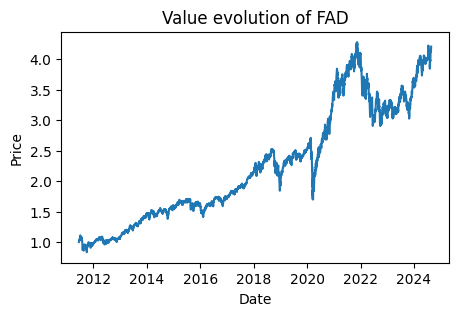

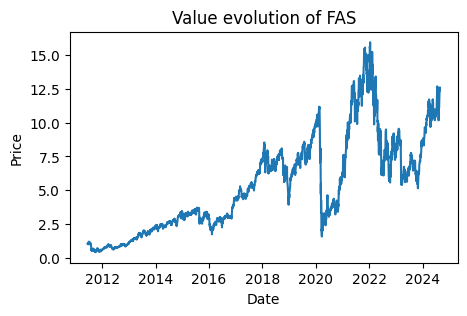

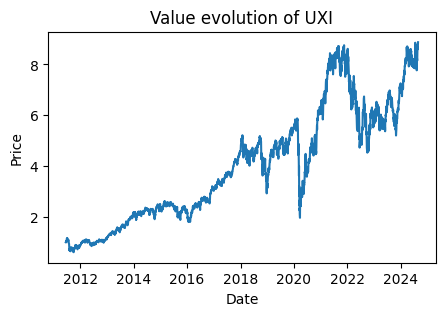

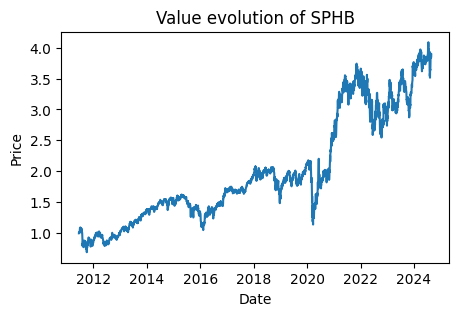

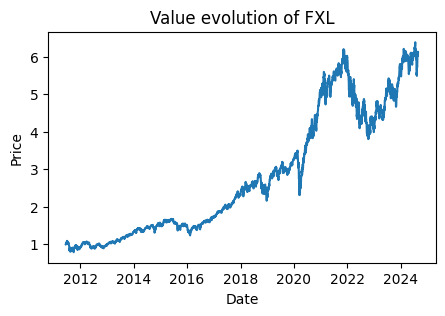

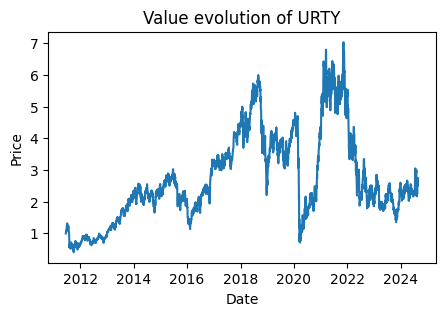

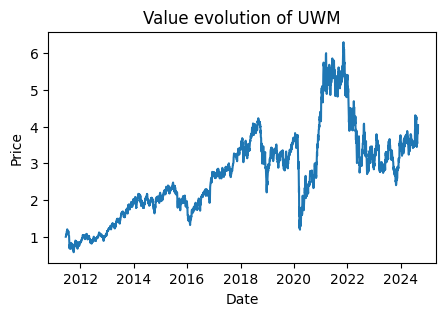

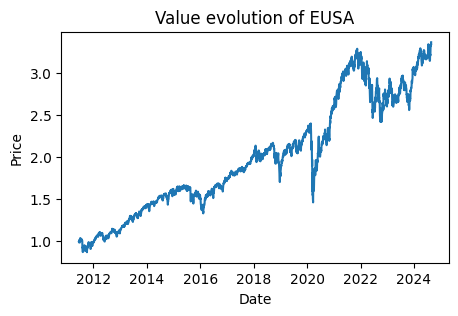

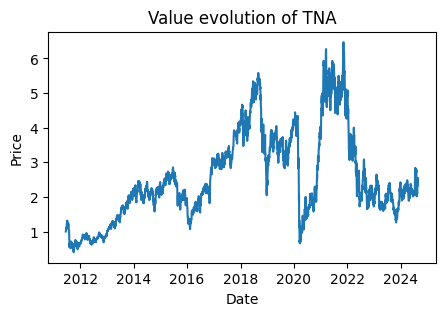

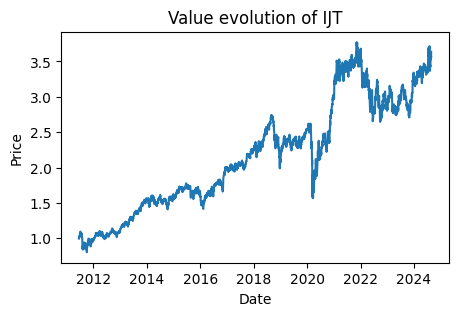

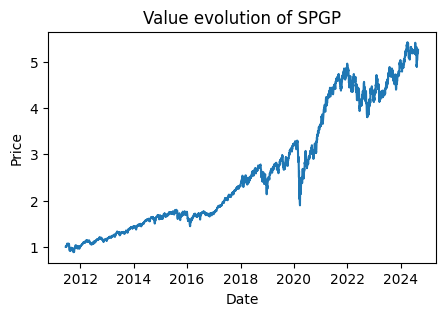

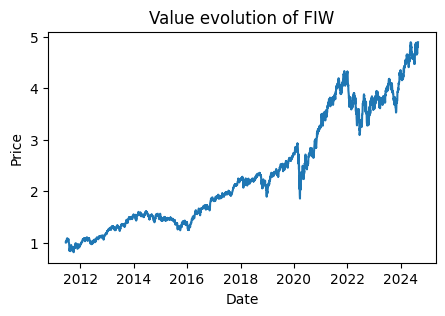

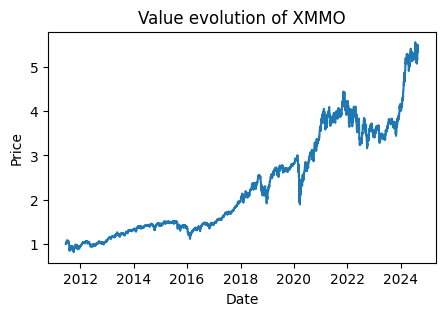

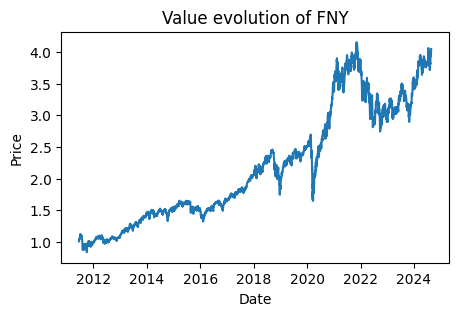

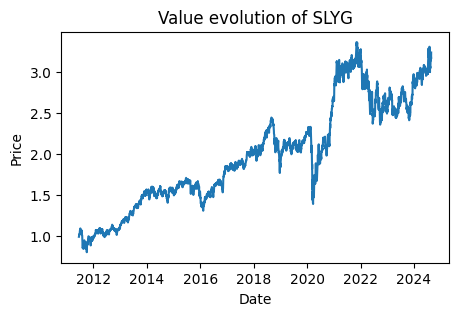

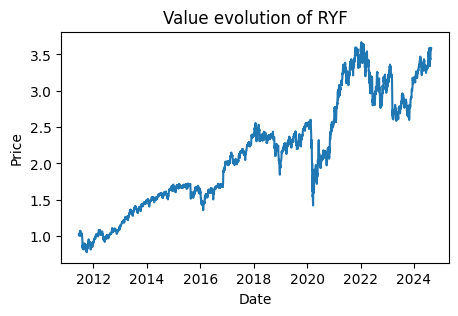

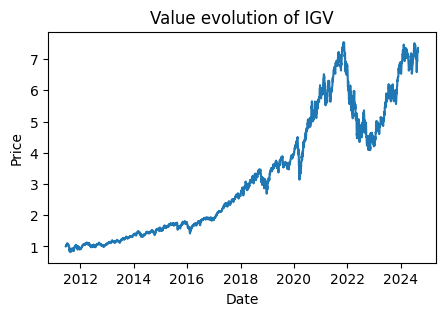

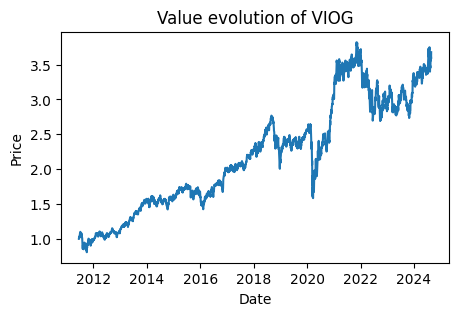

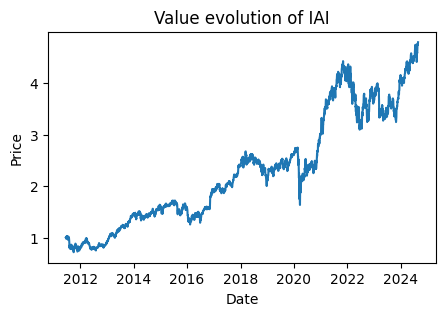

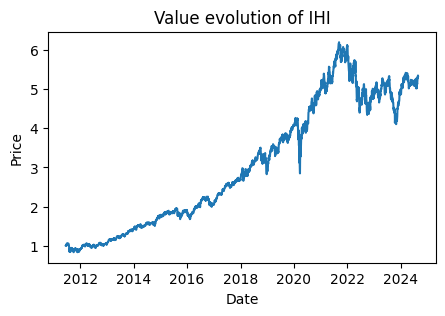

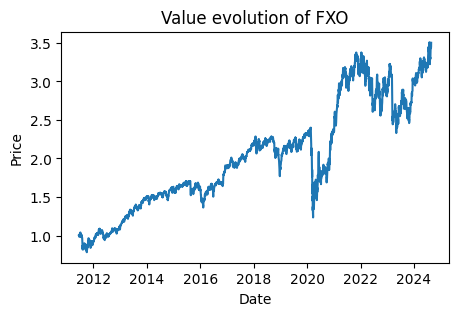

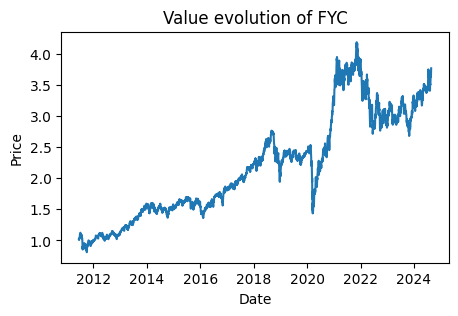

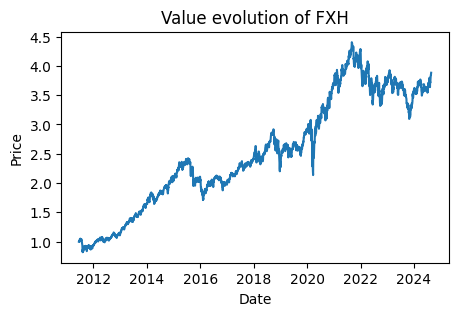

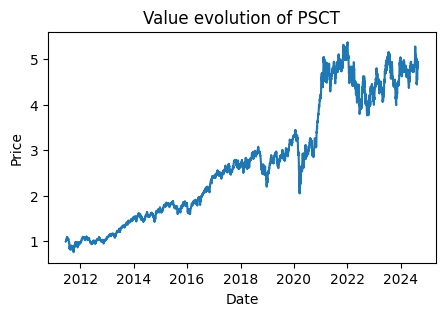

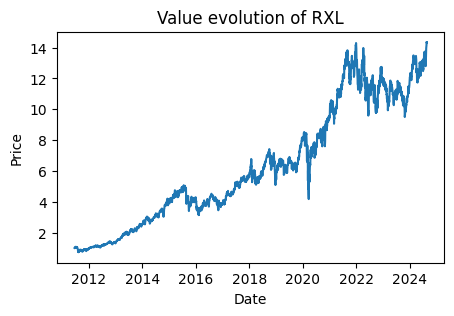

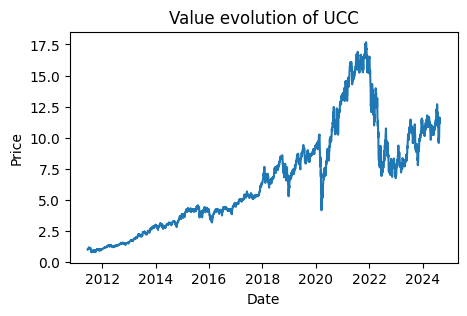

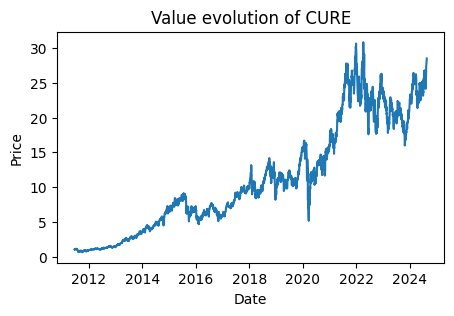

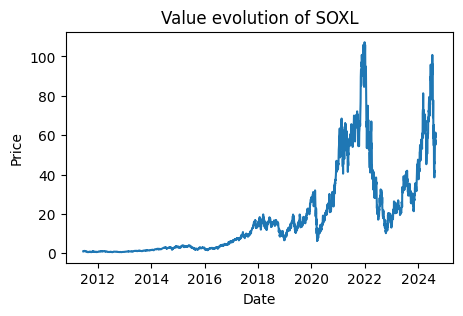

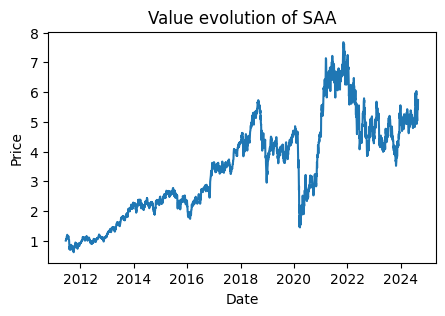

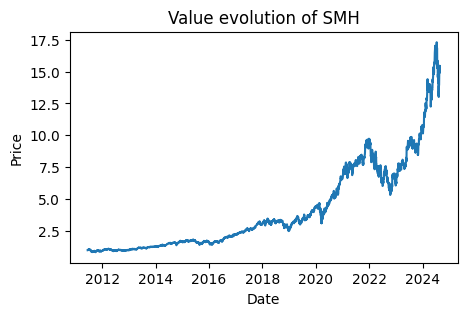

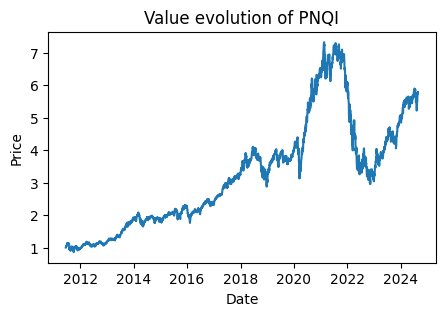

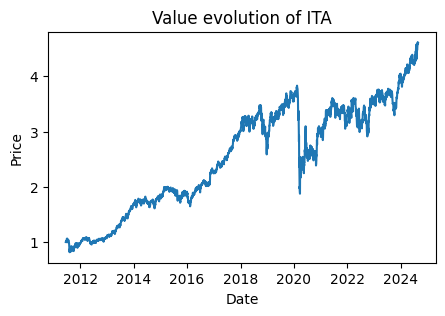

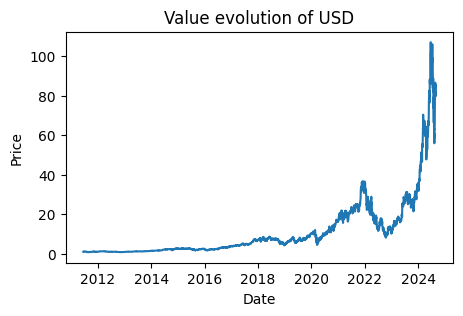

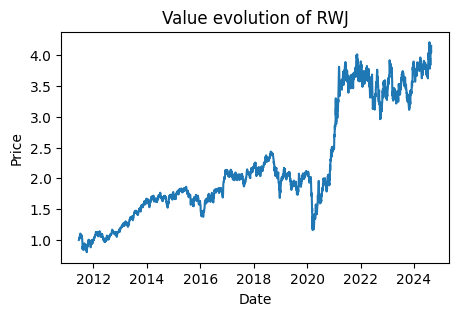

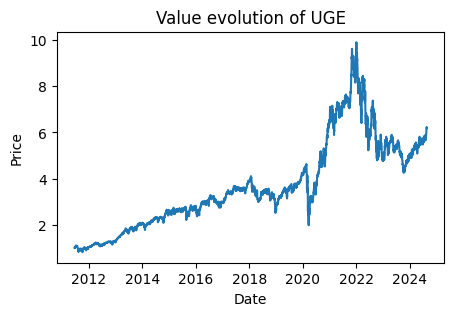

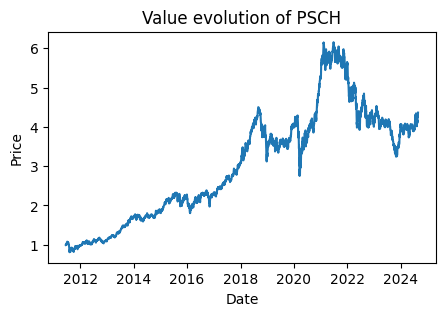

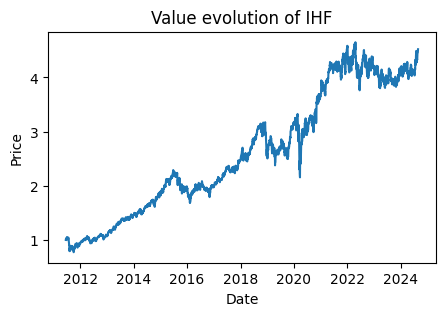

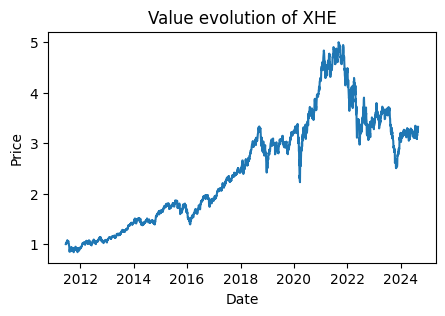

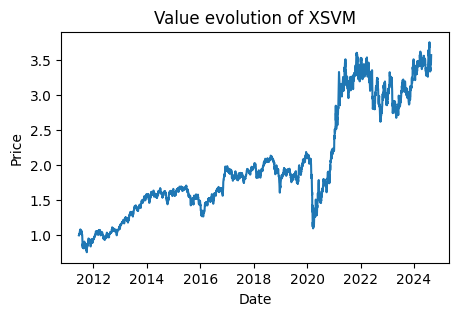

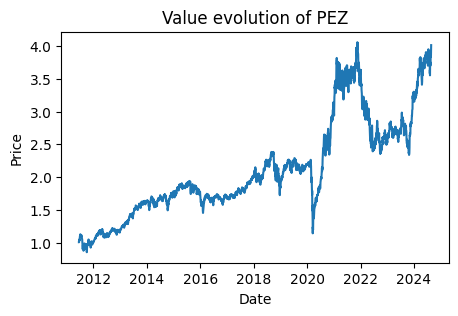

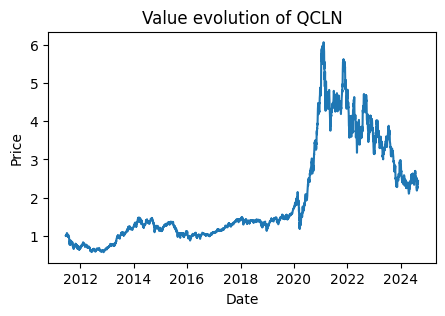

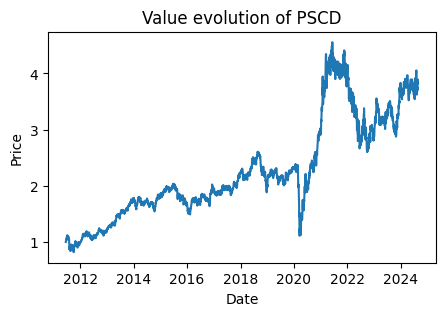

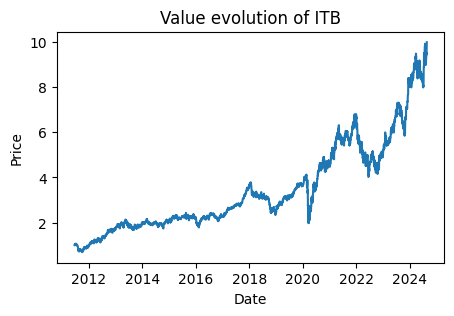

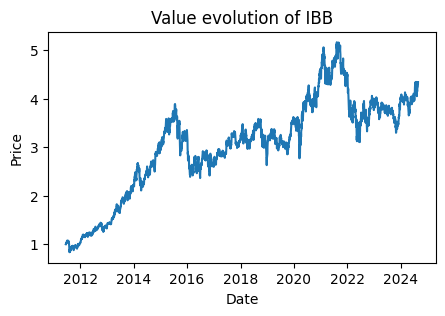

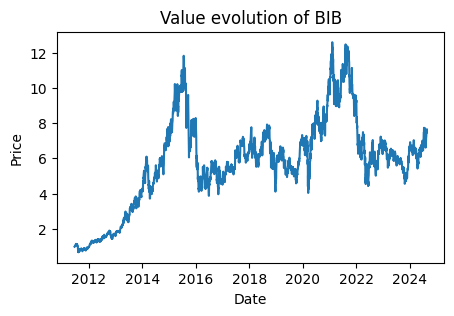

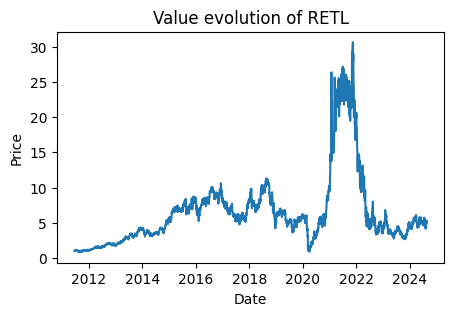

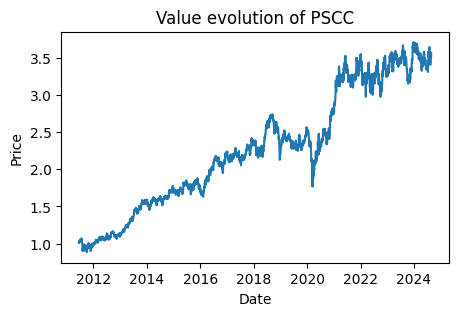

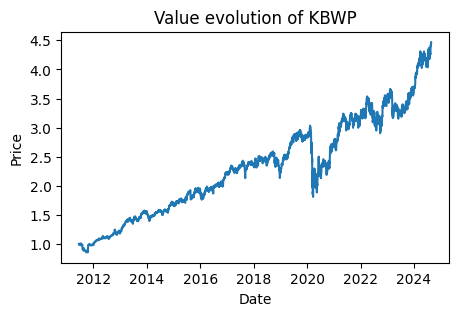

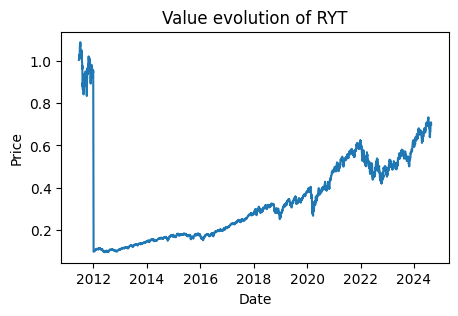

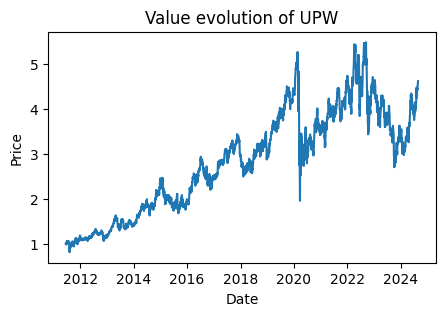

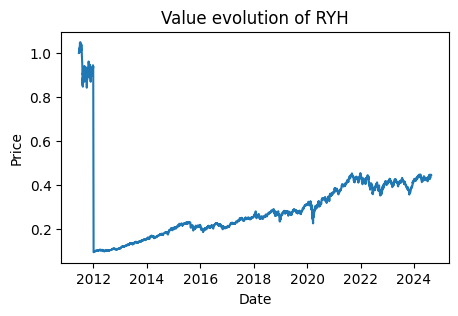

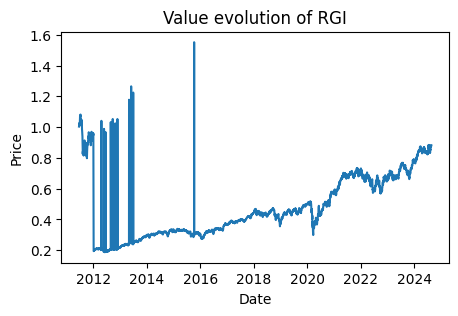

In [12]:
for symbol in cols_order:
    plt.figure(figsize=(5, 3))
    plt.plot((df_all_symbols_clipped[symbol] + 1).cumprod())
    plt.title(f"Value evolution of {symbol}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In the plots above we see strange discontinuities in the symbols RGI RYH RYT, so we will exclude them from the analysis.

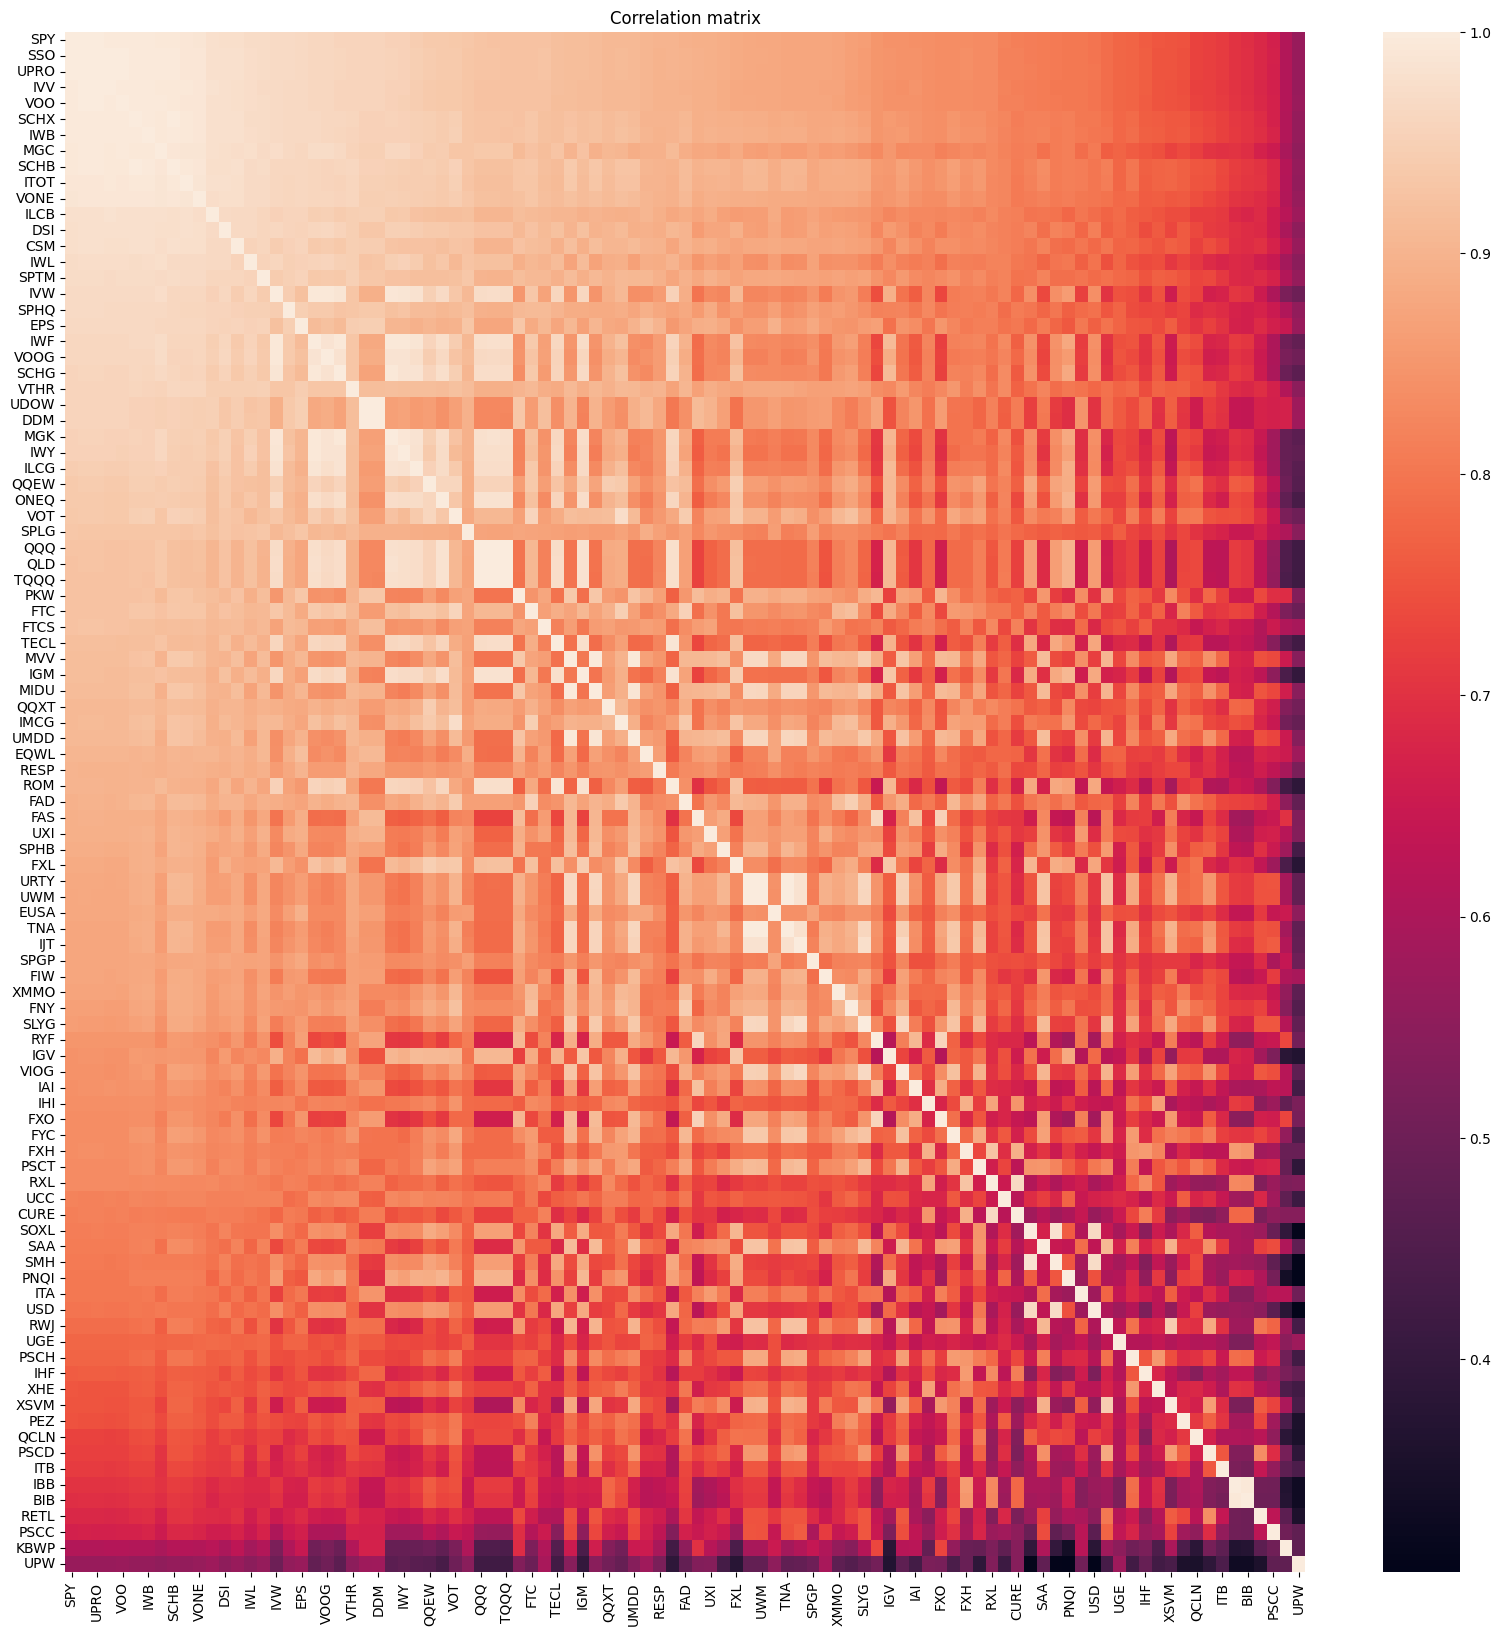

In [13]:
import seaborn as sns

df_corrs = df_all_symbols_clipped.corr()
cols_final = [col for col in cols_order if col not in ["RGI", "RYH", "RYT"]]
plt.figure(figsize=(20, 20))
sns.heatmap(df_corrs.loc[cols_final, cols_final], annot=False)
plt.title("Correlation matrix")
plt.show()

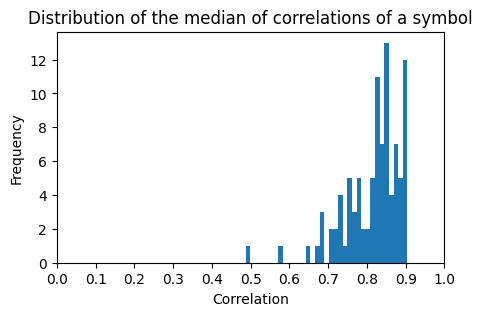

count    97.000000
mean      0.814464
std       0.074557
min       0.486856
25%       0.774267
50%       0.831440
75%       0.868426
max       0.904555
Name: 50%, dtype: float64

In [14]:
plt.figure(figsize=(5, 3))
plt.hist(df_corrs.loc[cols_final, cols_final].describe().T["50%"], bins=35)
plt.title("Distribution of the median of correlations of a symbol")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
# set xticks to 0.1 increments up to and including 1
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()
df_corrs.loc[cols_final, cols_final].describe().T["50%"].describe()

In [15]:
df_all_symbols_final = df_all_symbols_clipped[cols_final]

In [16]:
from statsmodels.tsa.stattools import pacf, acf

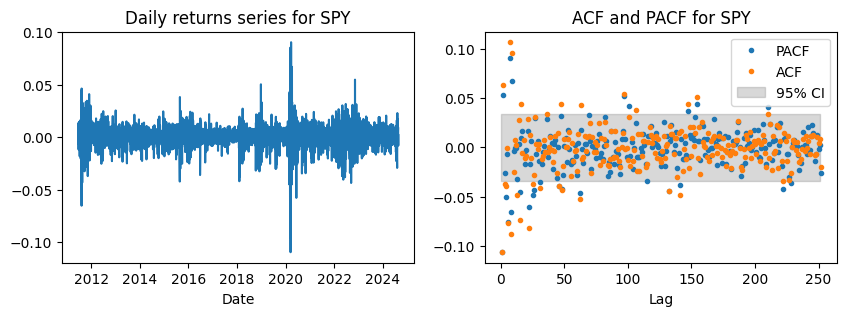

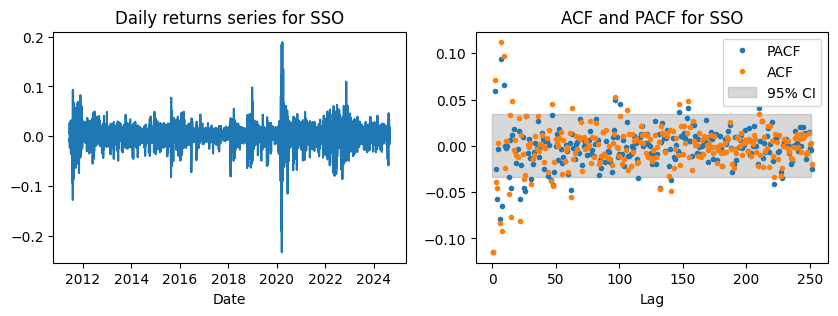

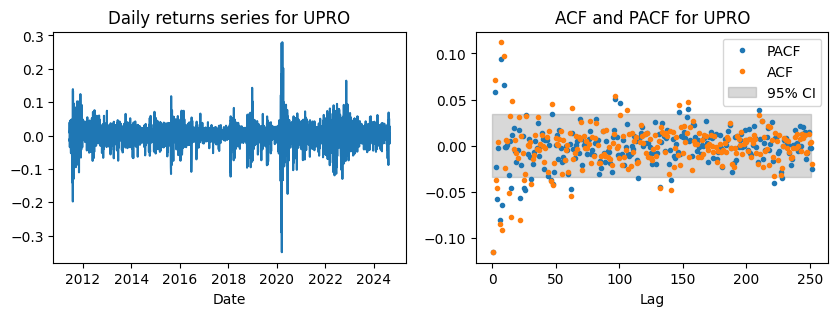

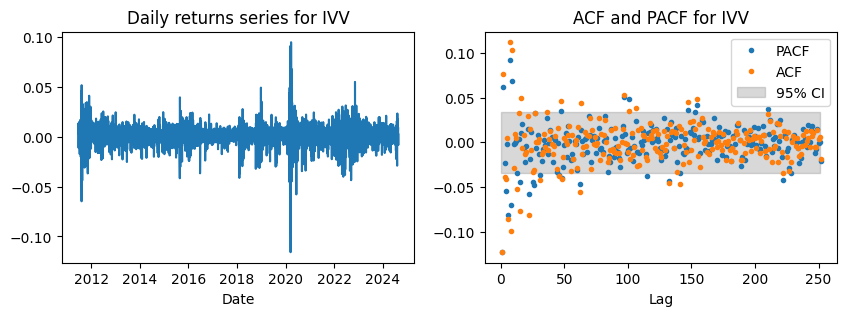

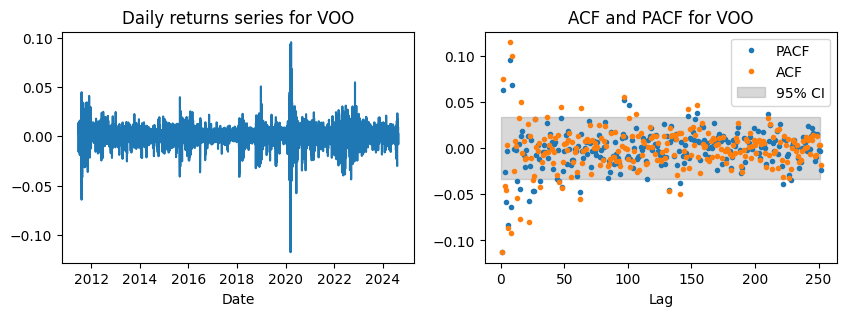

In [17]:
df_pacfs = pd.DataFrame()
df_acfs = pd.DataFrame()
band = 1.96 / np.sqrt(len(df_all_symbols_final["SPY"]))
# Look at a few of the first symbols
for i, col in enumerate(df_all_symbols_final.columns):
    pacf_values, pacf_conf_intervals = pacf(
        df_all_symbols_final[col], nlags=252, alpha=0.95
    )
    acf_values, acf_conf_intervals = acf(
        df_all_symbols_final[col], nlags=252, alpha=0.95
    )

    if i < 5:
        # Plot series on the laft + PACF and ACF in a plot on the right with an area indicating the confidence interval

        # Prepare canvas for 2 plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

        # Plot series
        ax1.plot(df_all_symbols_final[col])
        ax1.set_title(f"Daily returns series for {col}")
        # set axis labels
        ax1.set_xlabel("Date")

        # Plot ACF and PACF

        if df_pacfs.empty:
            df_pacfs = pd.DataFrame({col: pacf_values[1:]})
            df_acfs = pd.DataFrame({col: acf_values[1:]})
        else:
            df_pacfs[col] = pacf_values[1:]
            df_acfs[col] = acf_values[1:]

        ax2.plot(range(1, len(pacf_values)), pacf_values[1:], ".", label="PACF")
        ax2.plot(range(1, len(acf_values)), acf_values[1:], ".", label="ACF")

        ax2.fill_between(
            range(len(pacf_values[1:])),
            pacf_values[1:] * 0 - band,
            pacf_values[1:] * 0 + band,
            color="grey",
            alpha=0.3,
            label="95% CI",
        )
        ax2.legend()
        ax2.set_title(f"ACF and PACF for {col}")
        ax2.set_xlabel("Lag")
        plt.show()

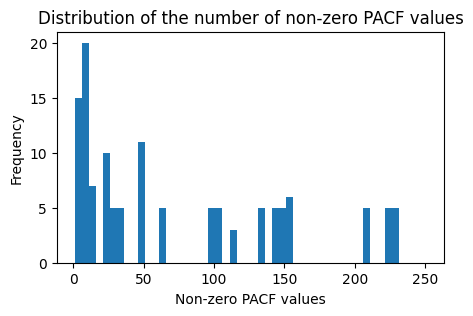

count    127.000000
mean      73.157480
std       73.538396
min        1.000000
25%        9.000000
50%       46.000000
75%      132.000000
max      228.000000
dtype: float64

In [18]:
df_pacfs_non_zero = abs(df_pacfs) > 1.96 / np.sqrt(len(df_all_symbols_final["SPY"]))

values_pacfs_non_zero = list()
for col in df_pacfs_non_zero.columns:
    values_pacfs_non_zero = values_pacfs_non_zero + list(
        df_pacfs_non_zero[col][df_pacfs_non_zero[col]].index + 1
    )

# histogram of non-zero PACF values
plt.figure(figsize=(5, 3))
plt.hist(values_pacfs_non_zero, bins=[1 + i * 5 for i in range(51)])
plt.title("Distribution of the number of non-zero PACF values")
plt.xlabel("Non-zero PACF values")
plt.ylabel("Frequency")
plt.show()
pd.Series(values_pacfs_non_zero).describe()

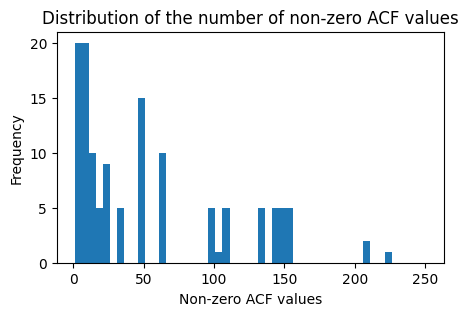

count    128.000000
mean      52.679688
std       55.792491
min        1.000000
25%        8.000000
50%       28.000000
75%       97.000000
max      222.000000
dtype: float64

In [19]:
df_acfs_non_zero = abs(df_acfs) > 1.96 / np.sqrt(len(df_all_symbols_final["SPY"]))

values_acfs_non_zero = list()
for col in df_acfs_non_zero.columns:
    values_acfs_non_zero = values_acfs_non_zero + list(
        df_acfs_non_zero[col][df_acfs_non_zero[col]].index + 1
    )

# histogram of non-zero ACF values
plt.figure(figsize=(5, 3))
plt.hist(values_acfs_non_zero, bins=[1 + i * 5 for i in range(51)])
plt.title("Distribution of the number of non-zero ACF values")
plt.xlabel("Non-zero ACF values")
plt.ylabel("Frequency")
plt.show()
pd.Series(values_acfs_non_zero).describe()

The ACF and pACF stats above indicate that the correlations are more pronounced on lags of up to 50 business days (i.e. about 2 months) and seem to have some peaks at about 100, 150 and 220 business days (though with progressivelyl lower frequency and correlation function values). On one hand this can be interpreted as a slight lack of stationarity (if we also observe the correlation function plots we see that the functions typically slowly decays to zero) and 3 seasonality frequencies.

/tmp/ipykernel_129305/2264765183.py:12: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / (frequencies), np.abs(fft_result))


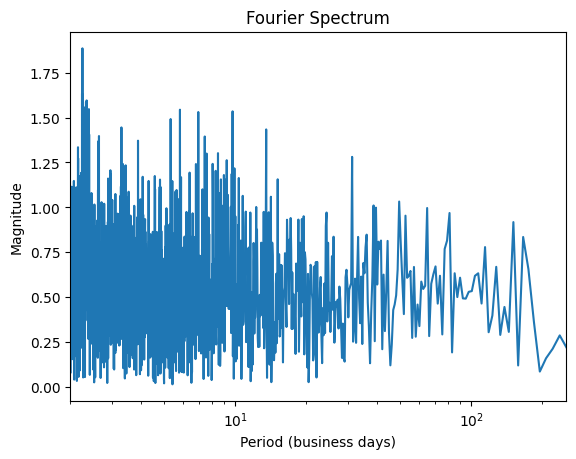

In [20]:
# Compute the FFT
time_series = df_all_symbols_final["SPY"]
fft_result = np.fft.fft(time_series)

# Calculate the frequencies corresponding to the FFT result
sample_rate = 1  # Assuming business day data
frequencies = np.fft.fftfreq(len(time_series), d=sample_rate)

# Plot the magnitude spectrum (optional)
import matplotlib.pyplot as plt

plt.plot(1 / (frequencies), np.abs(fft_result))
plt.xlabel("Period (business days)")
plt.ylabel("Magnitude")
plt.xscale("log")
plt.title("Fourier Spectrum")
plt.xlim(2, 252)
plt.show()

## Moving average analysis

Text(0, 0.5, 'frequency')

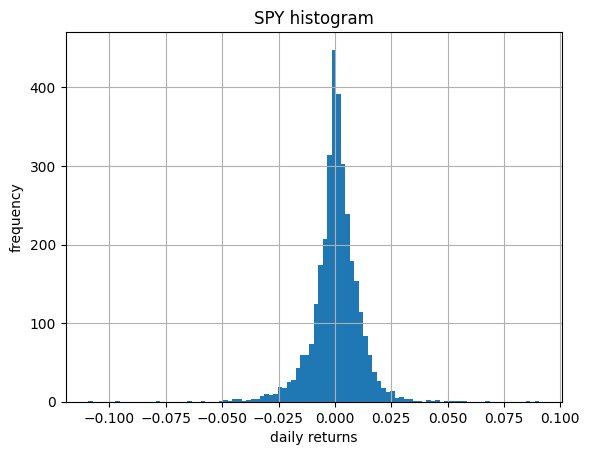

In [21]:
df_all_symbols_final["SPY"].hist(bins=100)
plt.title("SPY histogram")
plt.xlabel("daily returns")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

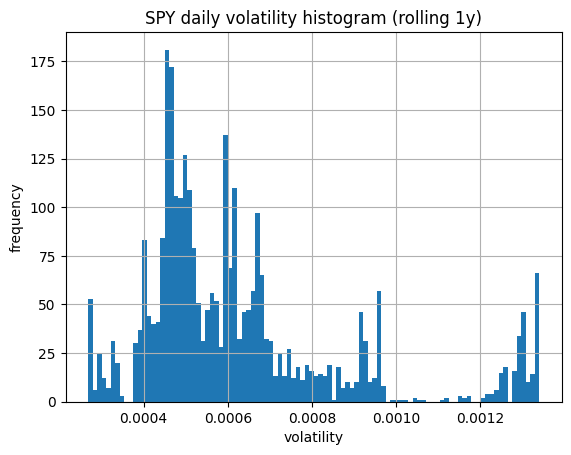

In [22]:
(df_all_symbols_final["SPY"].rolling(window=252).std() / np.sqrt(252)).hist(bins=100)
plt.title("SPY daily volatility histogram (rolling 1y)")
plt.xlabel("volatility")
plt.ylabel("frequency")

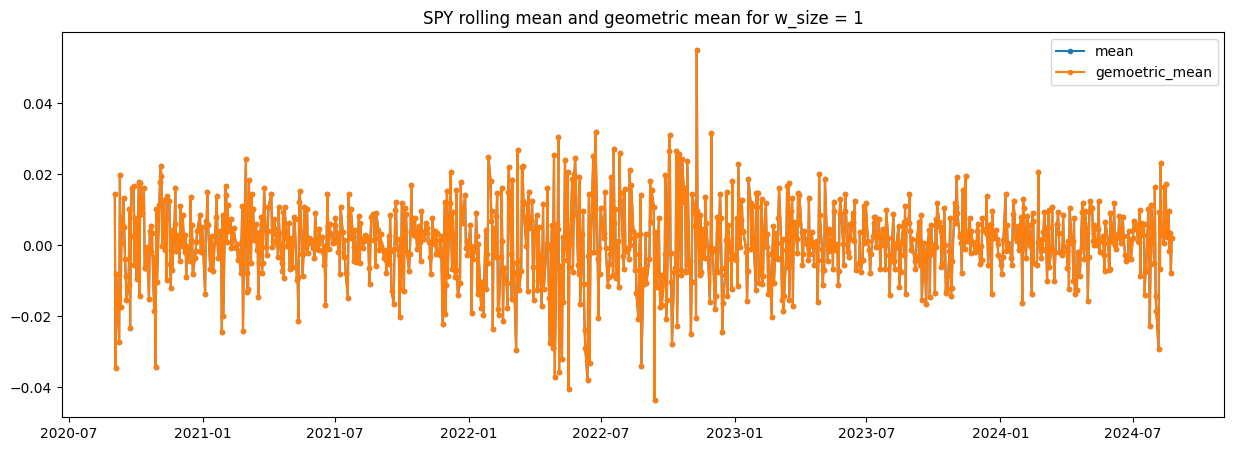

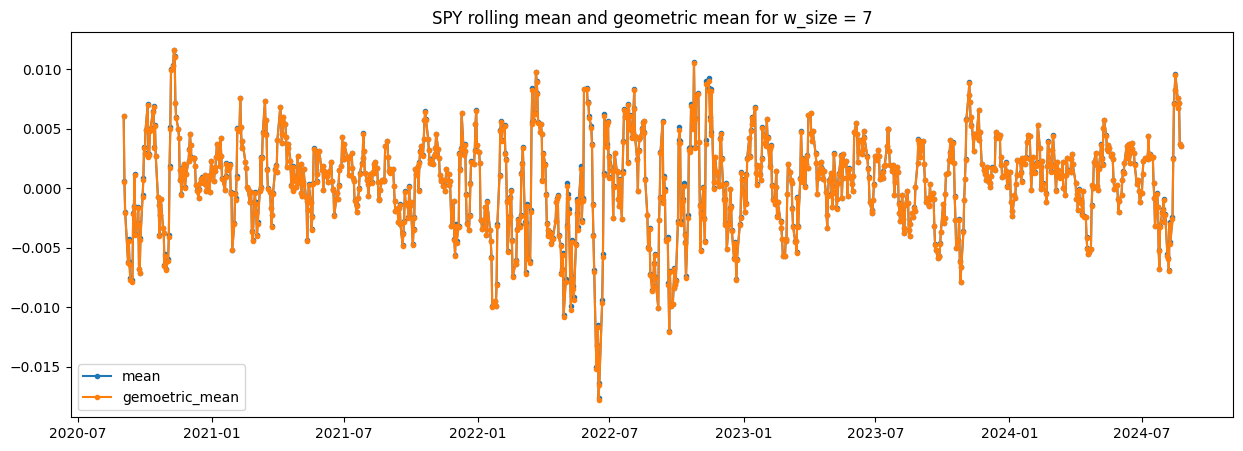

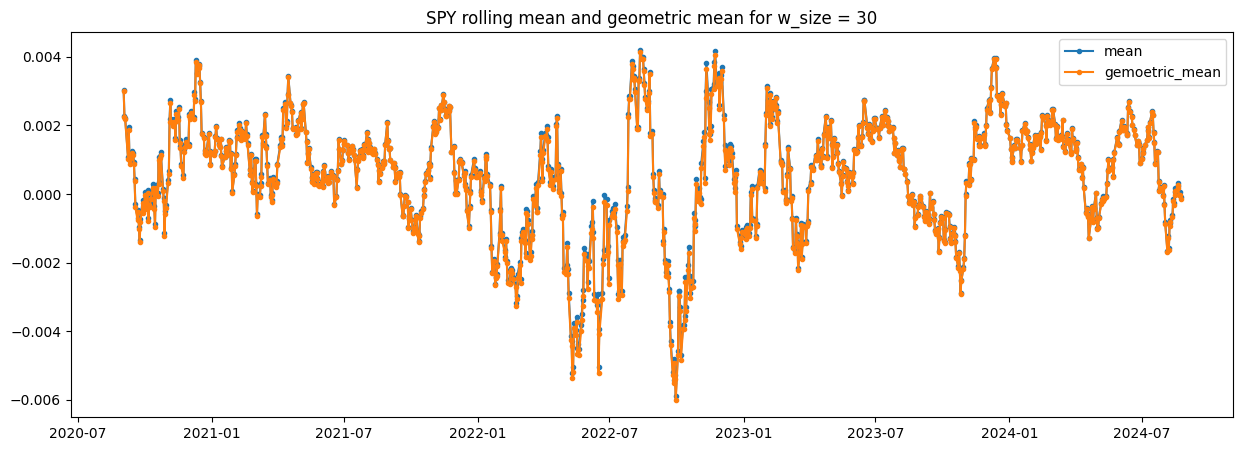

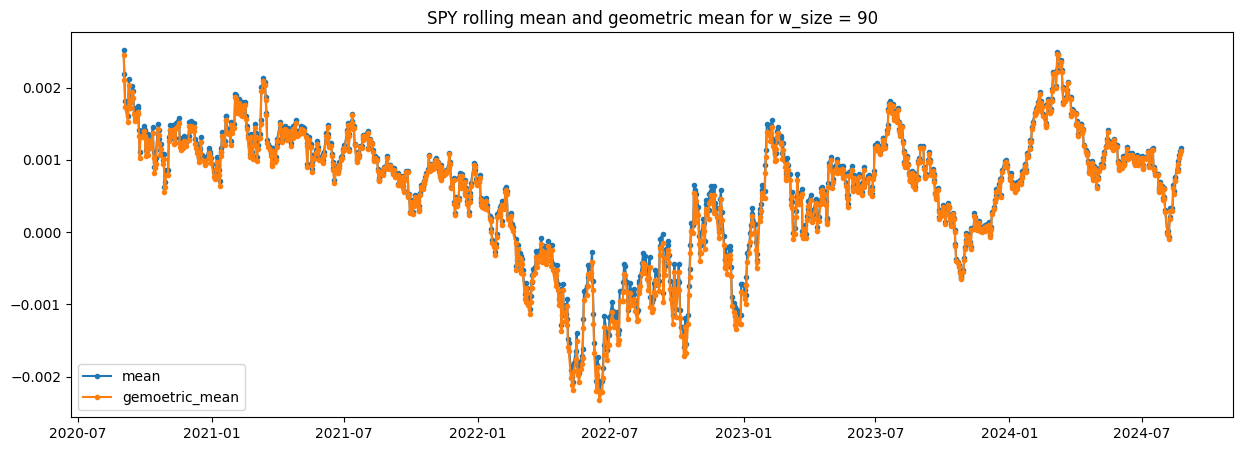

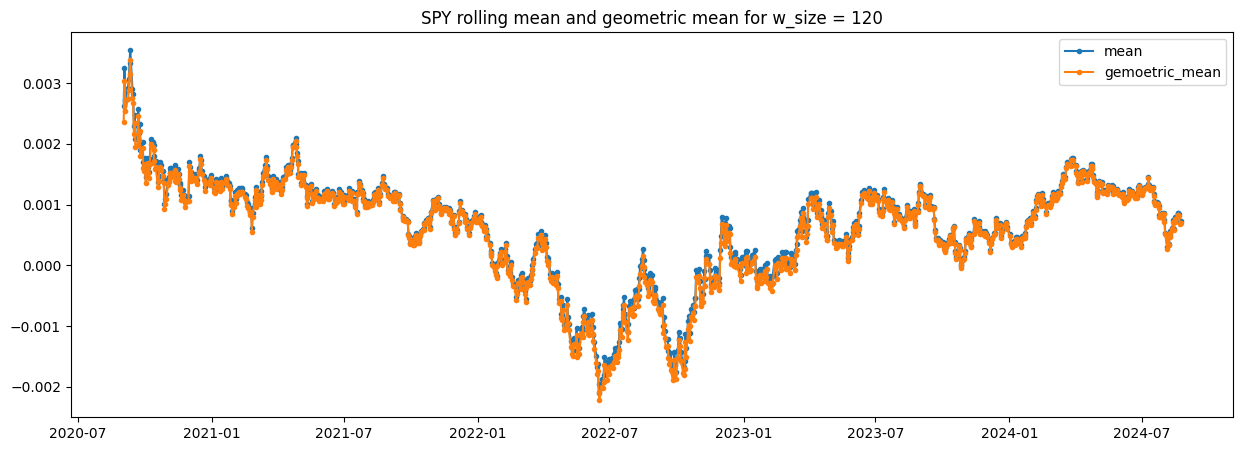

In [23]:
for w_size in [1, 7, 30, 90, 120]:
    n_points = 1000
    plt.figure(figsize=(15, 5))
    plt.plot(df_all_symbols_final["SPY"].rolling(w_size).mean()[-n_points:], ".-")
    plt.plot(
        df_all_symbols_final["SPY"]
        .rolling(w_size)
        .apply(lambda x: (1 + x).cumprod().iloc[-1] ** (1 / w_size) - 1)[-n_points:],
        ".-",
    )
    plt.legend(["mean", "gemoetric_mean"])
    plt.title(f"SPY rolling mean and geometric mean for w_size = {w_size}")
    plt.show()

In the plots above, we see that the series of returns is quite noisy. So it is unlikely that we will be able to predict very accurately the series value day by day. However, if we average out the series in a sliding window fashion, we can denoise the series and obtain a more well behaved target. 

In the next plots, we try to understand how well we can reproduce the price series using such a simple baseline.

Below, we can see that we get reasonable baselines, by extrapolating on a given window period by extracting the return averaged geometrically over the period. 

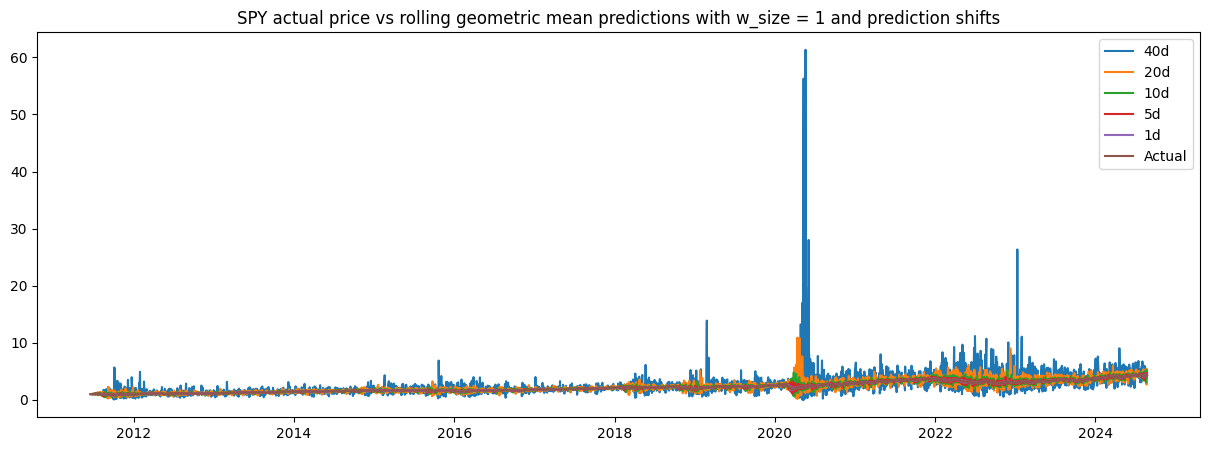

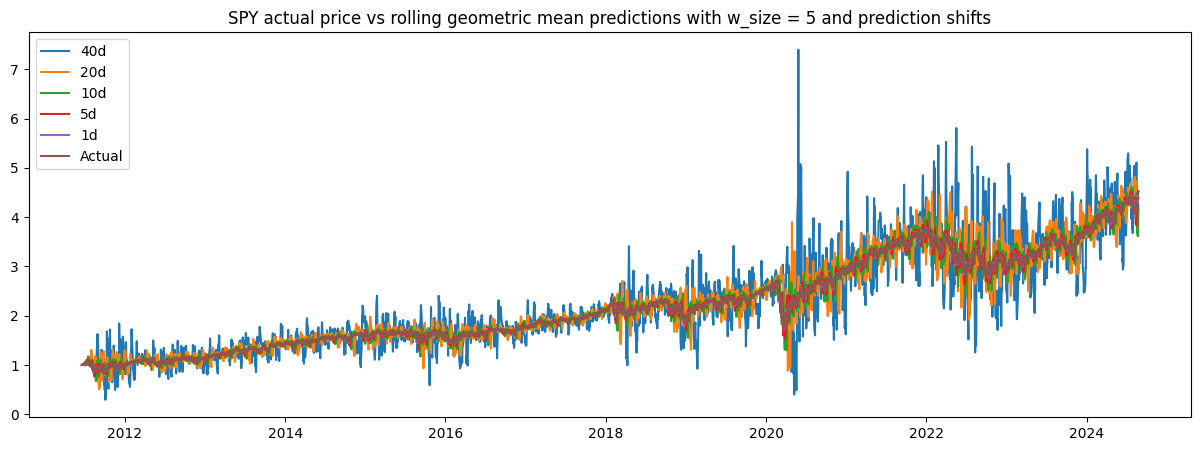

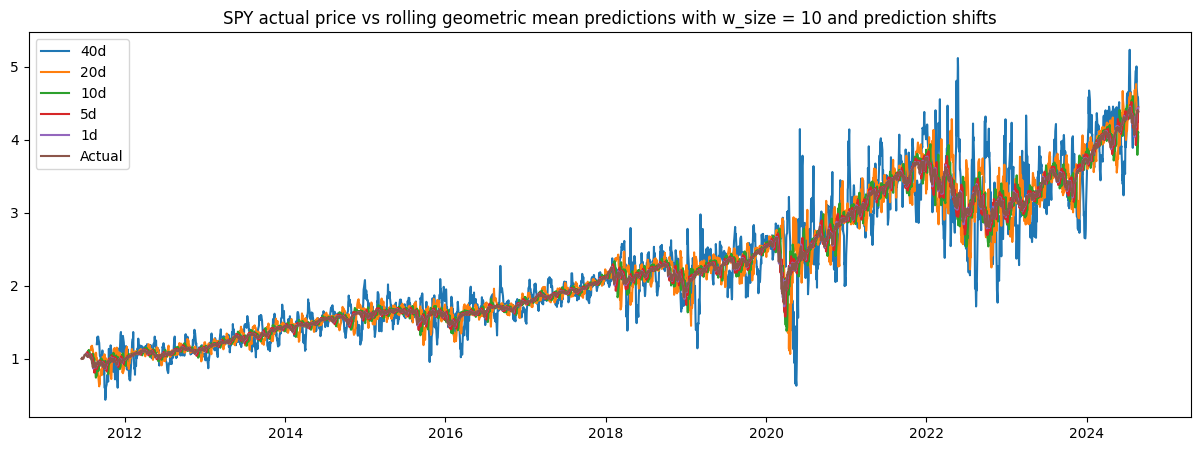

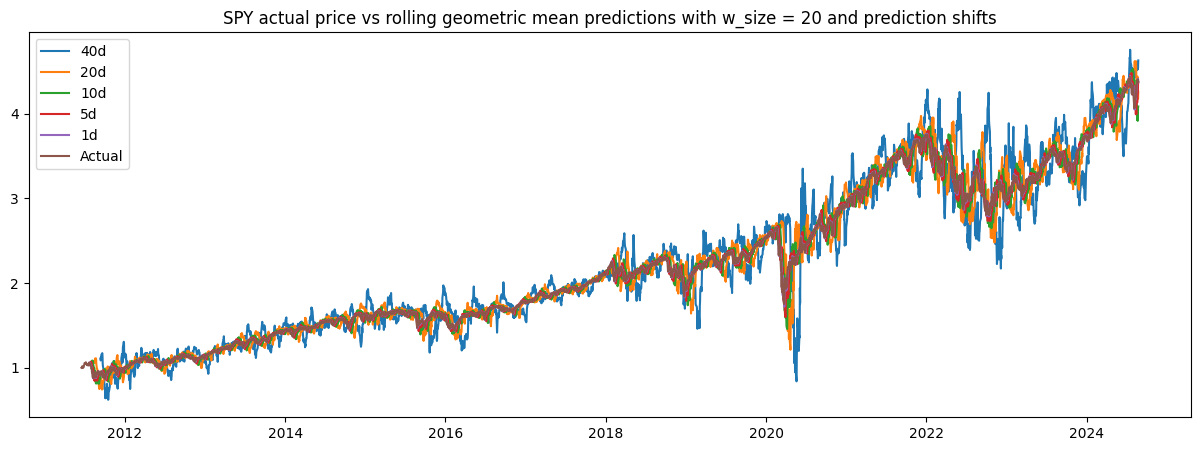

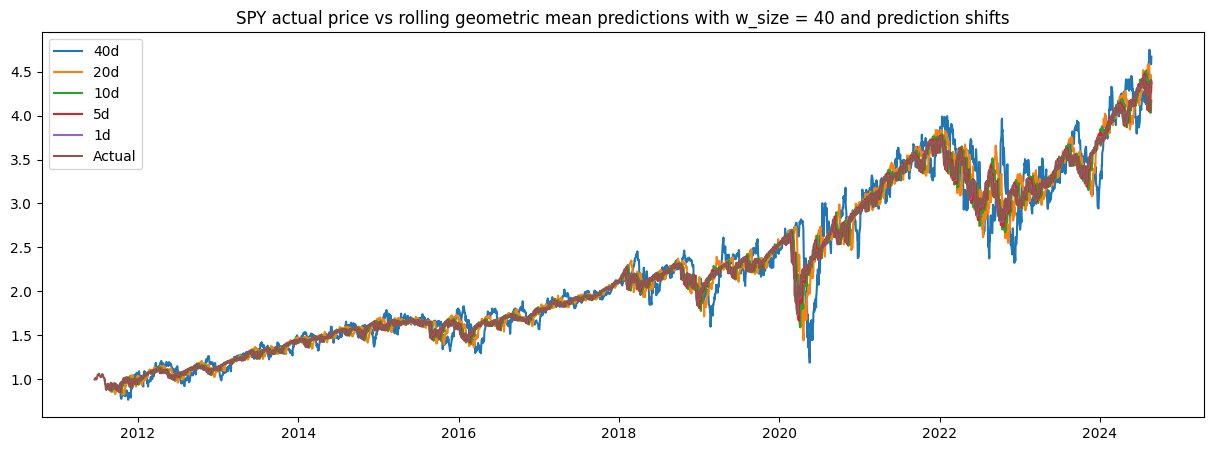

In [24]:
# predict based on the last w_size days average in the next 1, ... days
for w_size in [1, 5, 10, 20, 40]:
    plt.figure(figsize=(15, 5))
    legend = []
    for ndays in [40, 20, 10, 5, 1]:
        series = (1 + df_all_symbols_final["SPY"]).cumprod() * (
            1
            + df_all_symbols_final["SPY"]
            .rolling(w_size)
            .apply(lambda x: (1 + x).cumprod().iloc[-1] ** (1 / w_size) - 1)
        ) ** (ndays)
        plt.plot(series.shift(ndays))
        legend.append(f"{ndays}d")
    plt.plot((1 + df_all_symbols_final["SPY"]).cumprod())
    legend.append("Actual")
    plt.legend(legend)
    plt.title(
        f"SPY actual price vs rolling geometric mean predictions with w_size = {w_size} and prediction shifts"
    )
    plt.show()

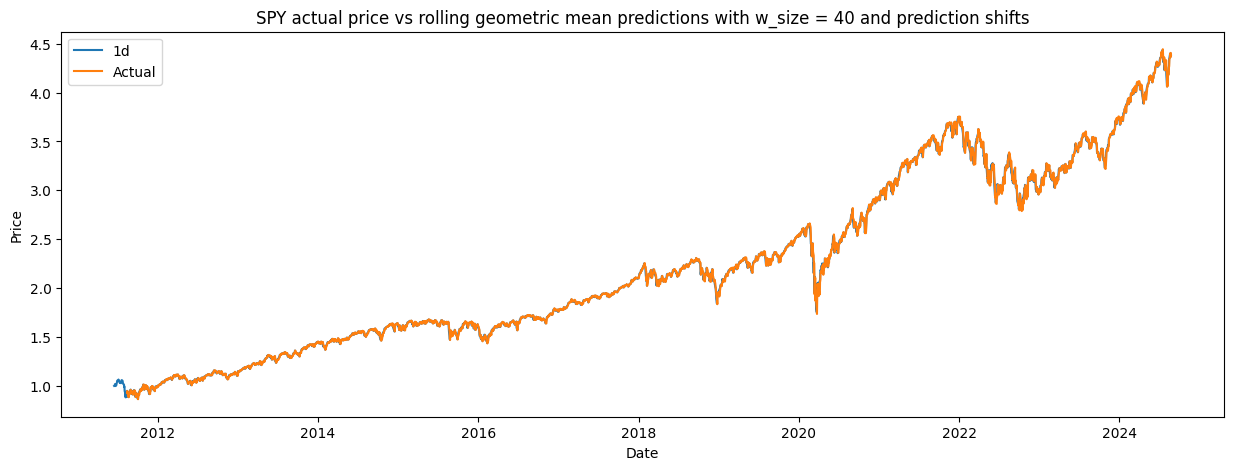

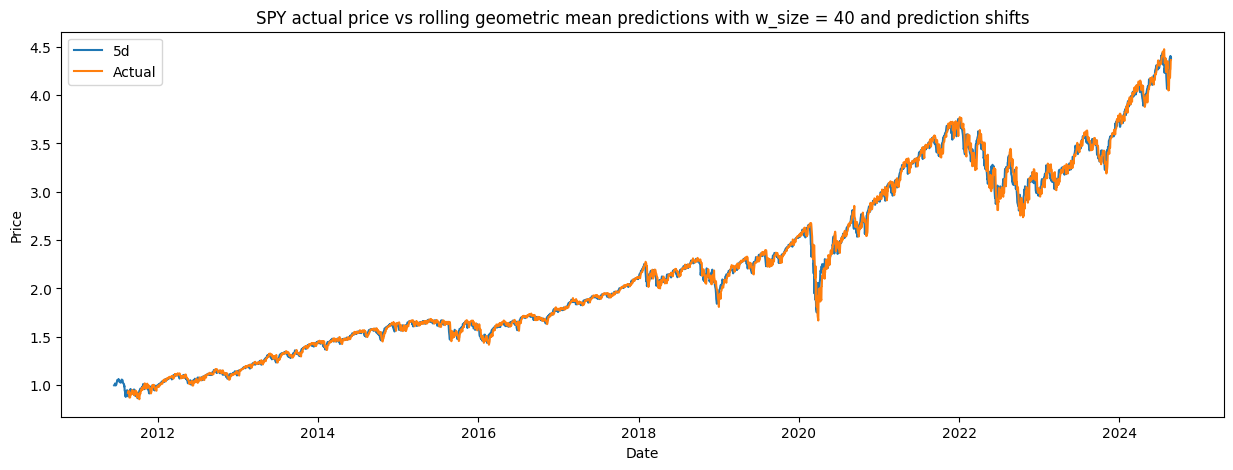

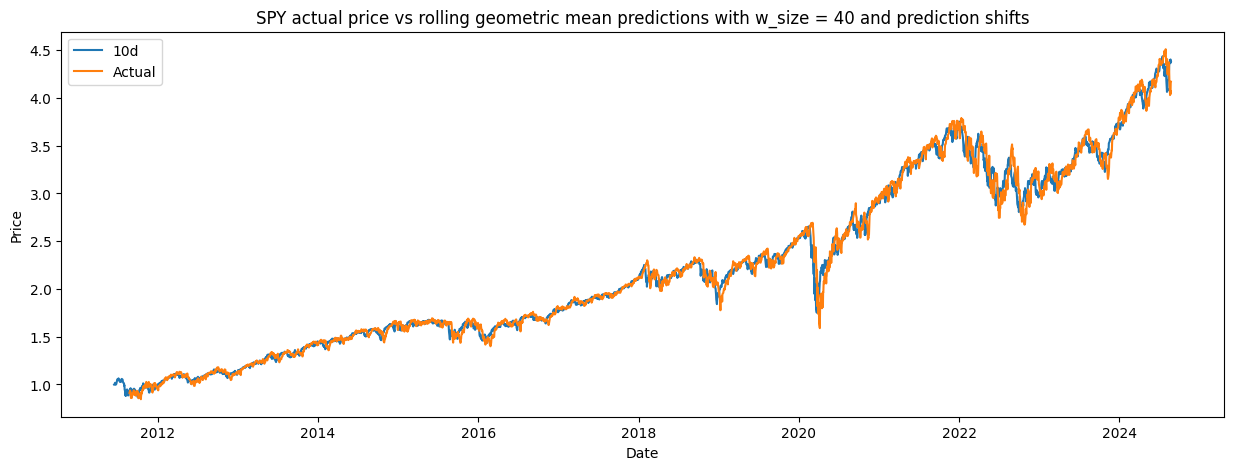

In [25]:
# predict based on the last w_size days average in the next 1, ... days
w_size = 40
for ndays in [1, 5, 10]:
    series = (1 + df_all_symbols_final["SPY"]).cumprod() * (
        df_all_symbols_final["SPY"]
        .rolling(w_size)
        .apply(lambda x: (1 + x).cumprod().iloc[-1] ** (1 / w_size))
    ) ** (ndays)
    plt.figure(figsize=(15, 5))
    plt.plot((1 + df_all_symbols_final["SPY"]).cumprod())
    plt.plot(series.shift(int(ndays)))
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(
        f"SPY actual price vs rolling geometric mean predictions with w_size = {w_size} and prediction shifts"
    )
    plt.legend([f"{ndays}d", "Actual"])
    plt.show()

We can see that for a few days we can predict reasonably well by extrapolating based on geometric averages. This suggests that these rolling window statistics are likely useful features.

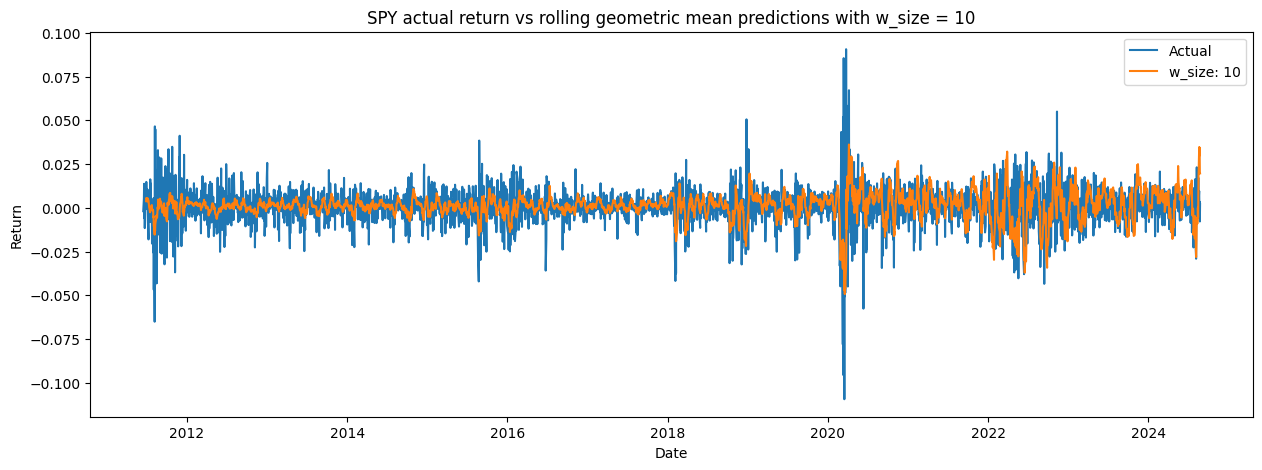

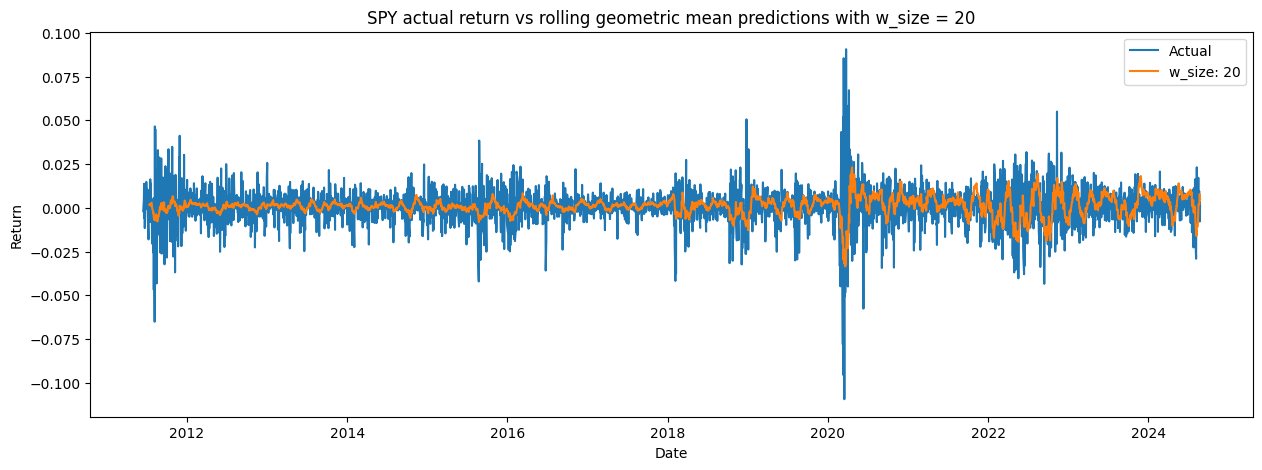

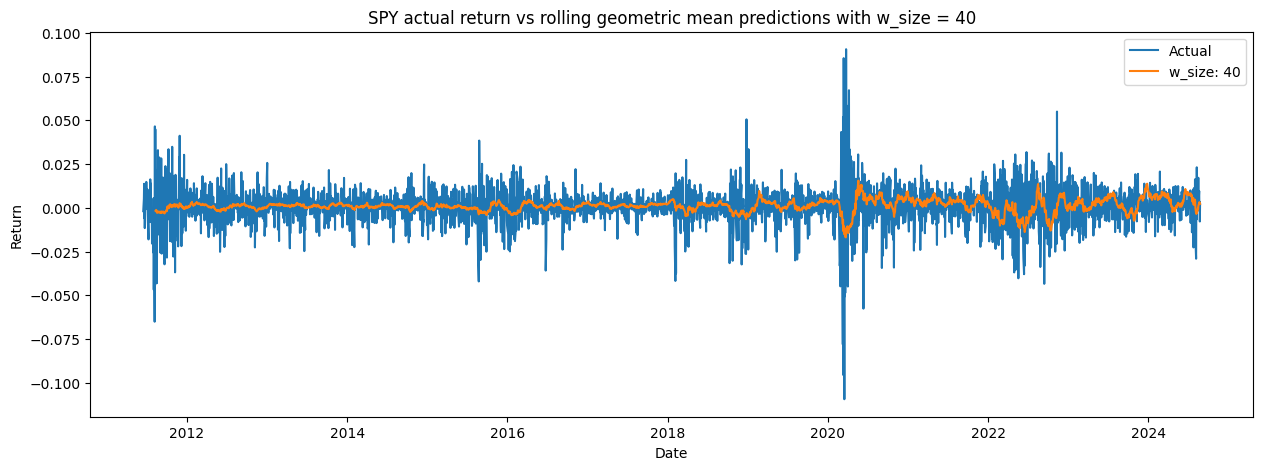

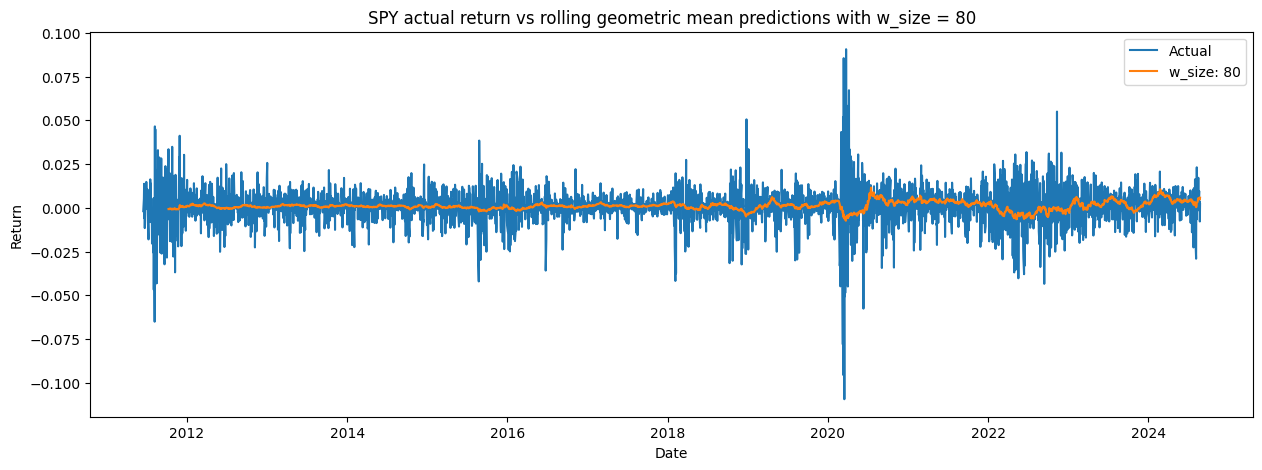

In [26]:
for w_size in [10, 20, 40, 80]:
    series = (1 + df_all_symbols_final["SPY"]).cumprod() * (
        df_all_symbols_final["SPY"]
        .rolling(w_size)
        .apply(lambda x: (1 + x).cumprod().iloc[-1] ** (1 / w_size) - 1)
    )
    plt.figure(figsize=(15, 5))
    plt.plot(df_all_symbols_final["SPY"])
    plt.plot(series)
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.title(
        f"SPY actual return vs rolling geometric mean predictions with w_size = {w_size}"
    )
    plt.legend(["Actual", f"w_size: {w_size}"])
    plt.show()

Conclusion: Predicting the average over the last n days is relatively solid and stable baseline. This also helps motivating using sliding window averages as features.

TODO: See SARIMA parameters as hyperparameters to fit under cross validation and choose a range to choose from to HPT the best univariate linear models. Then try to build on those by seeing them as a way to transform the series and then introduce multivariate non-linear models ???


Prepare training data with the following structure:
- moving/rolling average features for each data point (e.g., 1 day, week, month, year, avg, std, gradient estimates?) for each symbol. Let's list which aggs we will define:
    * Windows: 1 week, 4 week, 3 months, 1 year
    * Aggregations: avg, std
- shifted series values (to support AR like terms)




What is our assumption regarding the error term? I.e. the stochastic part of the process? This affects the loss and how we estimate uncertainty bands (e.g., if we use simulation to predict n steps ahead and have a MA model for the errors or if we use some analytic formula).


In principle, we could use networks to estimate the function 

$$
\begin{equation}
X_t = f(MA_1,\ldots, MA_k, X_{t-1}, \ldots, X_{t-N},\epsilon_t,\ldots, \epsilon_{t-p})
\end{equation}
$$

We could build non-linear versions of the ARIMA model by replacing linear weights by networks. However, working with such a complex errors structure will likely involve complex variational manipulations of the loss.

Another interesting approach consists of using ARIMA to model the linear patterns and then a neural network to model the non-linearities of the remaining residuals.
https://archive.ph/yJhYN





https://en.wikipedia.org/wiki/Vector_autoregression


What we will do next:
- Try (S)ARIMA and vector versions of ARIMA as strong baselines
- Feature engineering as described above so that each row has complete info (Markov like) and so that we can use an out of the box regressor like lightgbm or an MLP
- Sequence modelling with RNNs: at each step consume previous state and new vector of  values (multivariate, i.e., the vector of size 100) and predict next vector.

